<h1 style="text-align: center;">Brain Tumor MRI Classification using Deep Learning</h1>
<h2 style="text-align: center;">Comparative Study of CNN Architectures for Brain Tumor MRI Classification</h2>
<h3 style="text-align: center;">Simon VELLIN    |   Aleksandr SMOLIN    |  Nicholas RAUTH</h3>

This notebook implements several CNN-based approach to classify brain MRI images into 4 categories:
- **Glioma**$\to$ A type of brain tumor
- **Meningioma**$\to$ Another type of brain tumor
- **No Tumor**$\to$ Healthy brain scans
- **Pituitary**$\to$ Pituitary gland tumors

## Imports & Configuration

Libraries:

In [71]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
import kagglehub
from PIL import Image
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
from pathlib import Path
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.metrics import Precision, Recall
import os
import tensorflow as tf
from tensorflow.keras import Sequential, layers
from tensorflow.keras.applications import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall

import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential, layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall
from sklearn.utils.class_weight import compute_class_weight

import json
from pathlib import Path

Optional Setup for Apple Silicon Devices:

 TensorFlow will automatically pick the best device it finds (GPU via MPS or CPU) by default. But you can run this to confirm you’re actually running on the GPU (or CPU) and set TensorFlow’s memory-growth mode, which can prevent OOM crashes on M1/M2 machines.

In [6]:
print("Brain Tumor MRI Classification System")
print("Configuring device for Apple Silicon...")

if tf.config.list_physical_devices('GPU'):
    print("✅ MPS (Metal Performance Shaders) available")
    try:
        tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
        print("✅ GPU memory growth enabled")
    except:
        print("⚠️ GPU memory growth could not be enabled")
    device = "/GPU:0"  
    print("✅ Using Apple Silicon GPU (MPS)")
else:
    print("⚠️ GPU not available, using CPU")
    device = "/CPU:0"

print(f"TensorFlow version: {tf.__version__}")
print(f"Using device: {device}")

print("\nAvailable devices:")
for device_info in tf.config.list_physical_devices():
    print(f"  {device_info}")

Brain Tumor MRI Classification System
Configuring device for Apple Silicon...
⚠️ GPU not available, using CPU
TensorFlow version: 2.16.1
Using device: /CPU:0

Available devices:
  PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


# 1. DATA LOADING

In case you have the dataset already downloaded locally, place it in the repo's parent directory and rename it "data". Else, the cell will download the data from Kaggle.

In [ ]:
# IF LOCAL: locate data folder
project_root = Path().resolve().parent   
local_data   = project_root / "data"

if local_data.exists():
    print(f"✅ Using local data folder at {local_data}")
    base_path = local_data
else:
    # ELSE: download via kagglehub
    try:
        import kagglehub
        print("Local data not found, downloading via kagglehub…")
        base_path = Path(kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset"))
        print(f"✅ Download complete: {base_path}")
    except ImportError:
        raise RuntimeError(
            "❌ Could not find local data and kagglehub is not installed.\n"
            "Please either place your data in a `data/` folder or `pip install kagglehub`."
        )

# Define train & test paths
TRAIN_DATASET_PATH = base_path / "Training"
TEST_DATASET_PATH  = base_path / "Testing"

# Sanity check
assert TRAIN_DATASET_PATH.exists(), f"Training folder missing at {TRAIN_DATASET_PATH}"
assert TEST_DATASET_PATH.exists(),  f"Testing folder missing at {TEST_DATASET_PATH}"

print(f"Training data path: {TRAIN_DATASET_PATH}")
print(f"Testing  data path: {TEST_DATASET_PATH}")

✅ Using local data folder at /Users/simonvellin/Documents/BSE/TERM 3/HIGH DIMENSIONAL ANALYSIS/HOMEWORKS/data
Training data path: /Users/simonvellin/Documents/BSE/TERM 3/HIGH DIMENSIONAL ANALYSIS/HOMEWORKS/data/Training
Testing  data path: /Users/simonvellin/Documents/BSE/TERM 3/HIGH DIMENSIONAL ANALYSIS/HOMEWORKS/data/Testing


Ensure the below cells correctly detects for the four classes:

In [46]:
classes = sorted([d for d in os.listdir(TRAIN_DATASET_PATH) if os.path.isdir(os.path.join(TRAIN_DATASET_PATH, d))])
num_classes = len(classes)
print(f"Detected classes: {classes}")

Detected classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


# 2. DATA EXPLORATION

## a) Class Imbalance

In [47]:
# Count images per class
def count_images(folder):
    return {cls: len(os.listdir(os.path.join(folder, cls))) for cls in classes}

train_counts = count_images(TRAIN_DATASET_PATH)
test_counts  = count_images(TEST_DATASET_PATH)

print("Training counts:", train_counts)
print("Testing counts: ", test_counts)

Training counts: {'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}
Testing counts:  {'glioma': 300, 'meningioma': 306, 'notumor': 405, 'pituitary': 300}


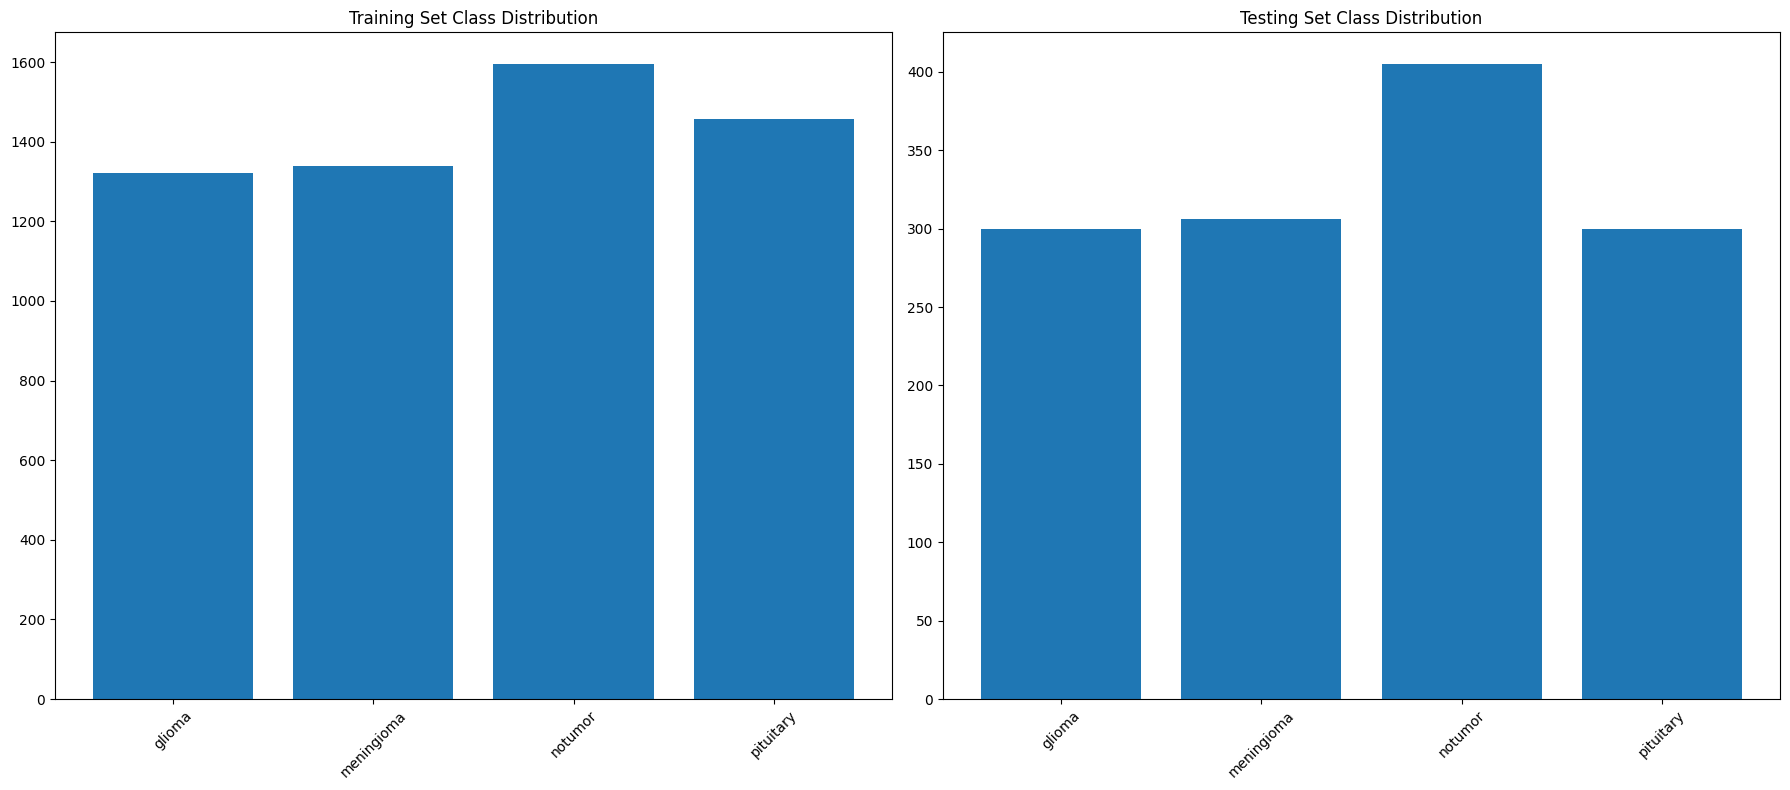

In [14]:
# Plot
plt.figure(figsize=(18,8))

plt.subplot(1,2,1)
plt.bar(train_counts.keys(), train_counts.values())
plt.title('Training Set Class Distribution')
plt.xticks(rotation=45)

plt.subplot(1,2,2)
plt.bar(test_counts.keys(), test_counts.values())
plt.title('Testing Set Class Distribution')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## b) Visualize Sample

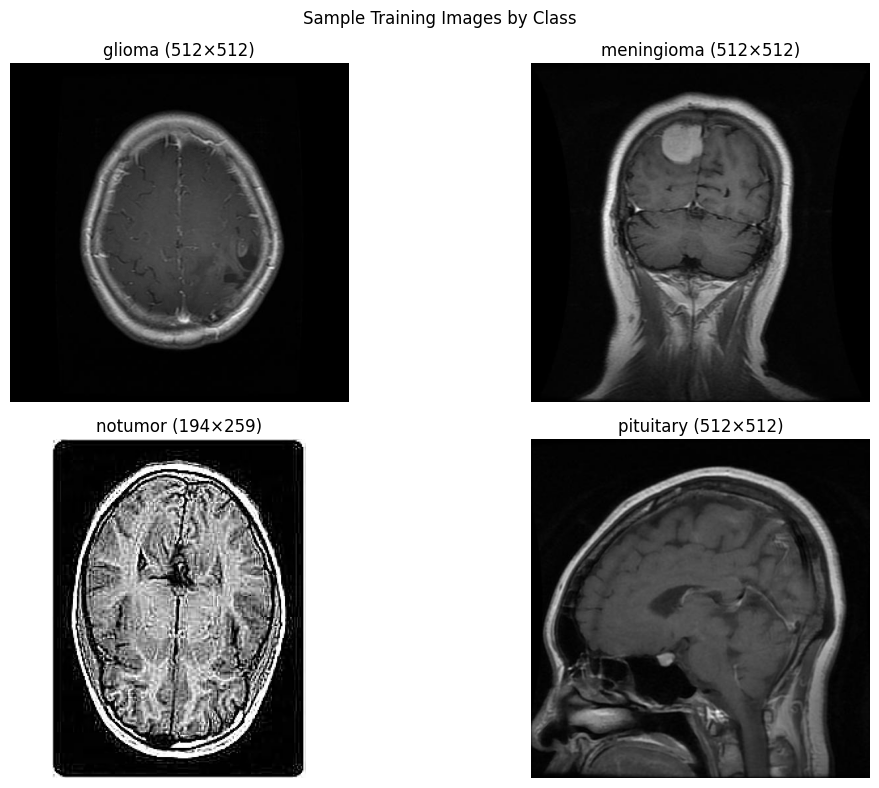

In [24]:
# Display one random sample per class (from training set)
plt.figure(figsize=(12,8))
for i, cls in enumerate(classes):
    ax = plt.subplot(2, 2, i+1)
    img_name = random.choice(os.listdir(os.path.join(TRAIN_DATASET_PATH, cls)))
    img_path = os.path.join(TRAIN_DATASET_PATH, cls, img_name)
    img = Image.open(img_path)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"{cls} ({img.size[0]}×{img.size[1]})")
    ax.axis('off')

plt.suptitle('Sample Training Images by Class')
plt.tight_layout()
plt.show()

## c) Resolution Imbalance

`We notice that there might be differences in image sizes, which might be a problem for model performance later on, so we plot the most used image resolution in training set:`

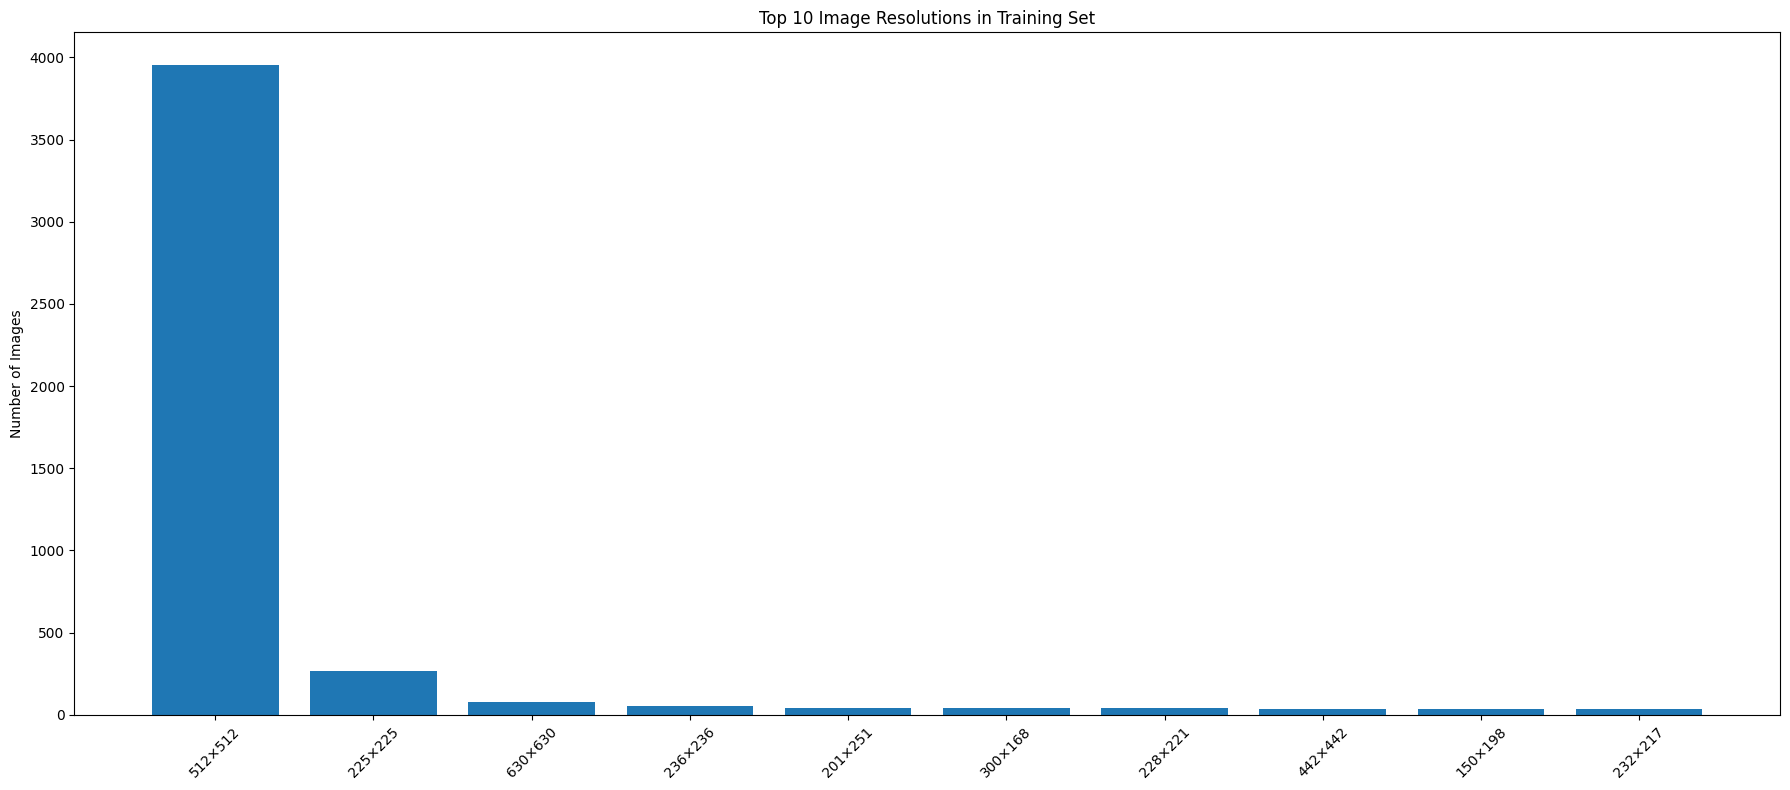

In [ ]:
# Gather and count all training-image resolutions
size_counts = Counter()
for cls in classes:
    cls_dir = os.path.join(TRAIN_DATASET_PATH, cls)
    for fname in os.listdir(cls_dir):
        w, h = Image.open(os.path.join(cls_dir, fname)).size
        size_counts[(w, h)] += 1

# Plot the top-10 most common 
common = size_counts.most_common(10)
labels  = [f"{w}×{h}" for (w, h), _ in common]
counts  = [cnt for _, cnt in common]

plt.figure(figsize=(18, 8))
plt.bar(labels, counts)
plt.title("Top 10 Image Resolutions in Training Set")
plt.xticks(rotation=45)
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()

`Indeed, although the size 512x512 is largely dominating, we have still too much variation, so we decide to resize all images to a fixed size`.

# 3. DATA WRANGLING

## a) Test Resizing

We start by previewing the resizing of one image to see if this technique maintains the core input needed (i.e. brain) at the center of the image to train our model.

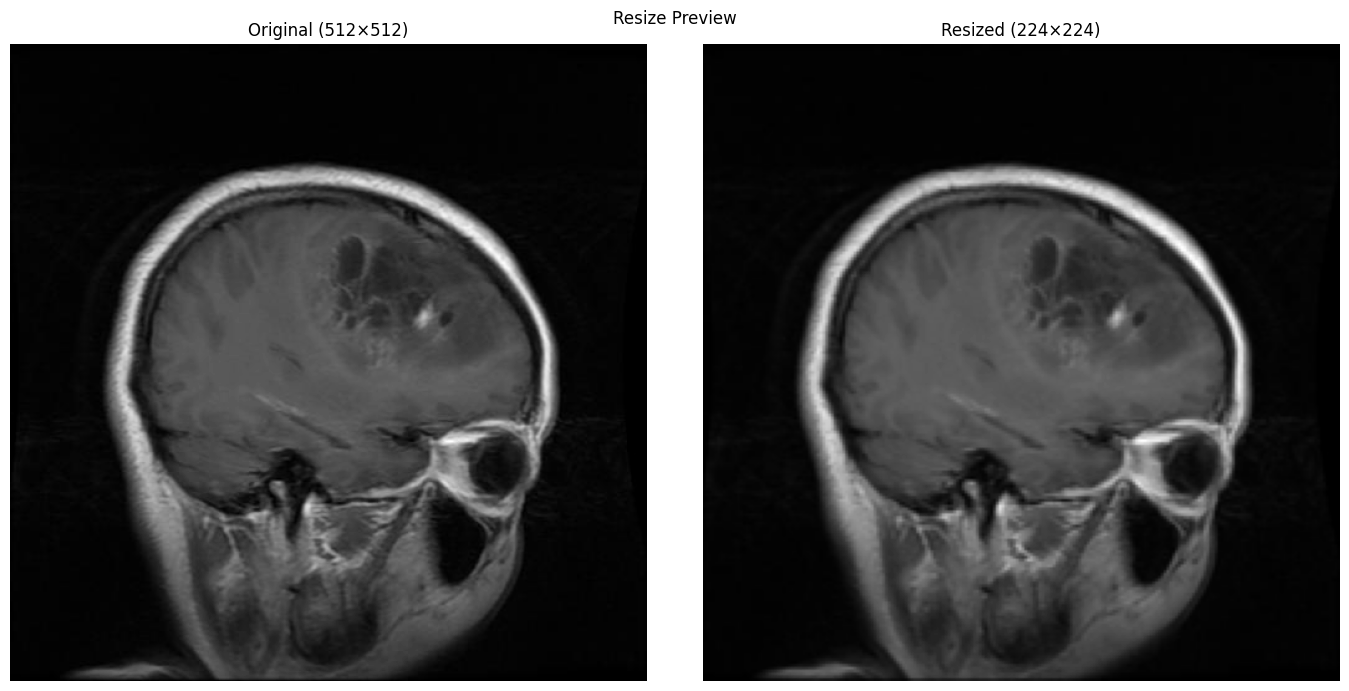

In [39]:
TARGET_SIZE = (224, 224)
sample_cls   = classes[0]
sample_file  = random.choice(os.listdir(os.path.join(TRAIN_DATASET_PATH, sample_cls)))
orig_img     = Image.open(os.path.join(TRAIN_DATASET_PATH, sample_cls, sample_file))
resized_img  = orig_img.resize(TARGET_SIZE)

plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.imshow(orig_img, cmap='gray')
plt.title(f"Original ({orig_img.size[0]}×{orig_img.size[1]})")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(resized_img, cmap='gray')
plt.title(f"Resized ({TARGET_SIZE[0]}×{TARGET_SIZE[1]})")
plt.axis('off')

plt.suptitle("Resize Preview")
plt.tight_layout()
plt.show()

## b) Resizing Loop

We start by defining the parameters of our resizing loop, and justify their respective value below:

In [40]:
BATCH_SIZE  = 32
IMG_SIZE    = (224, 224)    
SEED        = 42

`Why BATCH = 32?`

Although it does not change the fundamental algorithm, small batch consume less GPU memory, thus reducing the risk of out-of-memory errors. In addition, (32, 64, 128) tend to map more efficiently onto GPU memory allocators and tensor cores.

`Why SIZE = 224×224?`

Most widely adopted backbones (ResNet, VGG, EfficientNet, MobileNet, etc.) are pre‐trained on ImageNet images resized to **224×224**. By matching this input size:

1. **Leverage Transfer Learning**  
   - Import pre‐trained weights without architectural changes.  
   - Benefit from general “edge” and “texture” features learned on millions of images.

2. **Ensure Architectural Consistency**  
   - Convolutional blocks, pooling layers, and fully‐connected heads are tuned for 224×224.  
   - Preserves expected feature map dimensions, avoiding manual re‐engineering of strides or global pooling.

3. **Maintain Efficient Computation**  
   - Balances detail retention (sufficient resolution for tumor boundaries) with GPU memory limits.  
   - Smaller than full MRI resolution, but large enough to capture critical anatomy.

`Why SEED = 42?`

- **Reproducibility:** Ensures identical train/val/test splits, shuffles, and augmentations across runs.  
- **Fair Comparison:** Eliminates randomness when benchmarking different models.  
- **Standard Convention:** “42” is a common arbitrary choice for consistency.  

In [41]:
# 3.2 Load datasets with a fixed split
train_ds = image_dataset_from_directory(
    TRAIN_DATASET_PATH,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset='training',
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)
val_ds = image_dataset_from_directory(
    TRAIN_DATASET_PATH,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset='validation',
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)
test_ds = image_dataset_from_directory(
    TEST_DATASET_PATH,
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.


## c) Normalization & Augmentation

We now aim for a unified pipeline with MRI-specific normalization & augmentation. It benefits:

- **Consistency Across Models:**  
  A single `tf.data` workflow ensures every architecture sees identical data splits, resizing, normalization, and augmentations.  

- **Reproducibility:**  
  Fixed `SEED` in loading and each augmentation layer guarantees the same shuffles and transformations, enabling fair, repeatable comparisons.  

- **Medical-Grade Augmentation:**  
  Conservative random flips, rotations (±10°), small translations (±5%) and zooms (±5%) mimic realistic MRI variations without distorting pathology.  

- **Performance & Scalability:**  
  On-the-fly batching, mapping, and prefetching leverage `AUTOTUNE` for GPU-efficient data throughput, crucial when benchmarking multiple backbones.

In [42]:
preprocess_layer = layers.Rescaling(1./255)

augmenter = tf.keras.Sequential([
    layers.RandomFlip('horizontal', seed=SEED),
    layers.RandomRotation(0.1,   seed=SEED),
    layers.RandomTranslation(0.05, 0.05, seed=SEED),
    layers.RandomZoom(0.05,      seed=SEED),
])

def preprocess(image, label, augment=False):
    image = preprocess_layer(image)
    if augment:
        image = augmenter(image)
    return image, label

# 3.4 Apply to datasets & prefetch
train_ds = train_ds.map(lambda x, y: preprocess(x, y, augment=True)) \
                   .prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.map(lambda x, y: preprocess(x, y, augment=False)) \
                 .prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.map(lambda x, y: preprocess(x, y, augment=False)) \
                 .prefetch(tf.data.AUTOTUNE)

print(" Unified data pipeline ready")

 Unified data pipeline ready


This setup lays a rigorous foundation for our comparative study of CNN architectures, ensuring that any performance gains stem from model design—not data inconsistencies.

# 4. MODEL 1 - Baseline CNN (Epoch = 10 | LR = 1e-3)

## a) Implementation

`Key choices made:`

- **ReLU activation**  
  - Introduces nonlinearity, avoids vanishing gradients, and is computationally cheap.

- **padding='same'**  
  - Preserves spatial dimensions after convolution, making it easier to stack layers and maintain feature-map alignment.

- **Softmax output**  
  - Converts raw logits into a probability distribution over the 4 classes, ensuring outputs sum to 1 and are interpretable.

- **Categorical cross-entropy loss**  
  - Measures the divergence between the predicted probability distribution and the one-hot true labels; it’s the standard choice for multi-class classification.  

In [ ]:
# Model Definition
model = Sequential([
    # Normalize inputs
    layers.Rescaling(1./255, input_shape=(224, 224, 3)),

    # Block 1
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),

    # Block 2
    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),

    # Block 3
    layers.Conv2D(128, 3, activation='relu', padding='same'),
    layers.MaxPooling2D(),

    # Classifier
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

# Training Parameters
history = model.fit(
    train_ds,       
    validation_data=val_ds,
    epochs=10,
    verbose=2
)

# Evaluate on the test set
test_loss, test_acc = model.evaluate(test_ds, verbose=2)        # One line per epoch (no per-batch progress bar
print(f"\nScratch CNN Test Accuracy: {test_acc:.4f}")

/opt/anaconda3/envs/brushup_env/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,938,948 (49.36 MB)

 Trainable params: 12,938,948 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
143/143 - 69s - 481ms/step - accuracy: 0.2652 - loss: 1.3861 - val_accuracy: 0.3047 - val_loss: 1.3824
Epoch 2/3
143/143 - 70s - 490ms/step - accuracy: 0.2729 - loss: 1.3849 - val_accuracy: 0.3047 - val_loss: 1.3803
Epoch 3/3
143/143 - 69s - 479ms/step - accuracy: 0.2729 - loss: 1.3847 - val_accuracy: 0.3047 - val_loss: 1.3796
41/41 - 5s - 130ms/step - accuracy: 0.3089 - loss: 1.3812

Scratch CNN Test Accuracy: 0.3089


## b) Training Plots

The below cell is a `generic training & validation metrics per epoch plot` which will be used after each model to have a standardized 2×2 view in case the four metrics (Accuracy, Loss, Precision, Recall) were computed, else it simply skip the metric.

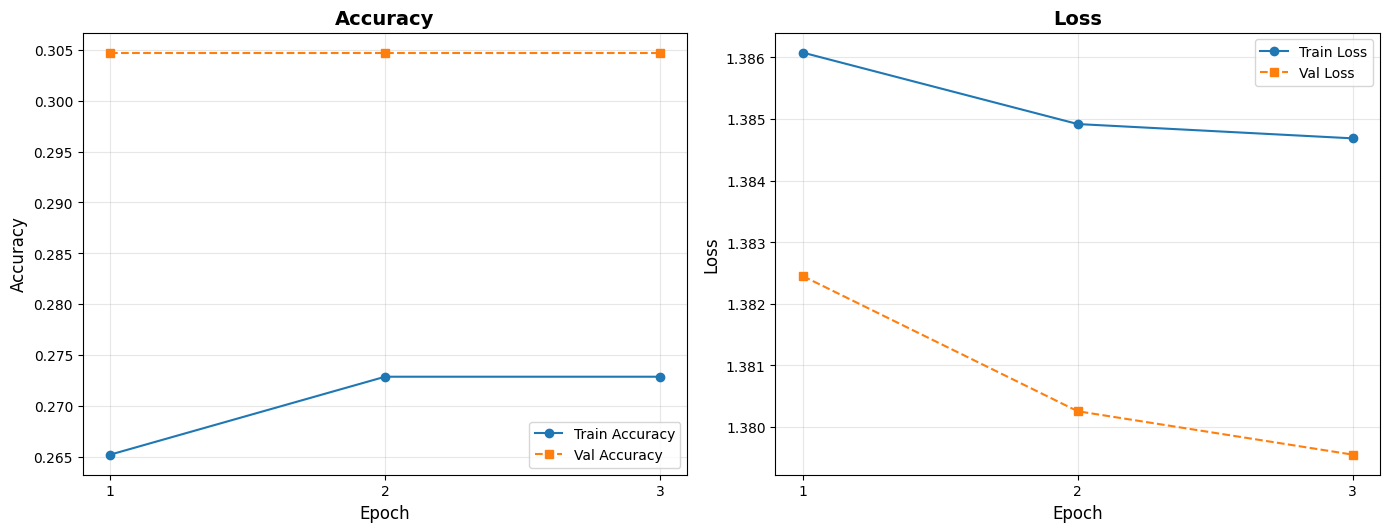

In [58]:
# metrics to plot
metrics = {
    'Accuracy':    ('accuracy', 'val_accuracy'),
    'Loss':        ('loss',     'val_loss'),
    'Precision':   ('precision','val_precision'),
    'Recall':      ('recall',   'val_recall'),
}

epochs = range(1, len(history.history['accuracy']) + 1)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

colors = {
    'train': 'tab:blue',
    'val':   'tab:orange'
}
styles = {
    'train': '-',
    'val':   '--'
}

for ax, (title, (train_key, val_key)) in zip(axes, metrics.items()):
    # skip if metric not in history
    if train_key not in history.history:
        ax.set_visible(False)
        continue

    ax.plot(epochs, history.history[train_key], color=colors['train'],
            linestyle=styles['train'], marker='o', label=f'Train {title}')
    ax.plot(epochs, history.history[val_key], color=colors['val'],
            linestyle=styles['val'], marker='s', label=f'Val {title}')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel(title, fontsize=12)
    ax.legend(loc='best')
    ax.grid(alpha=0.3)
    ax.set_xticks(epochs)

plt.tight_layout()
plt.show()

## c) Results & Comment

2025-06-17 18:28:09.313869: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Classification Report:

              precision    recall  f1-score   support

      glioma       0.00      0.00      0.00       300
  meningioma       0.00      0.00      0.00       306
     notumor       0.31      1.00      0.47       405
   pituitary       0.00      0.00      0.00       300

    accuracy                           0.31      1311
   macro avg       0.08      0.25      0.12      1311
weighted avg       0.10      0.31      0.15      1311



/opt/anaconda3/envs/brushup_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/brushup_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/brushup_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

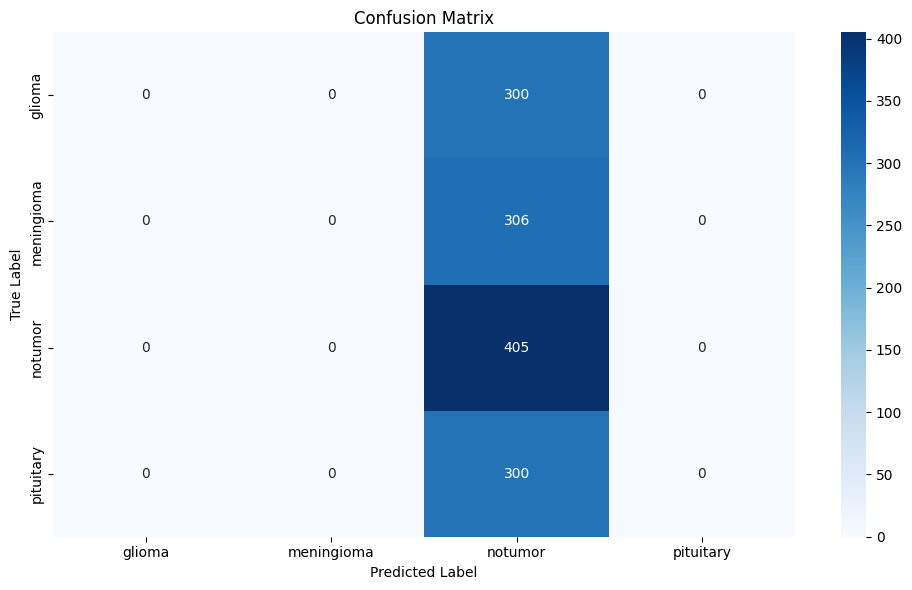

In [ ]:
# Collect ground-truth and predictions
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
y_true = np.argmax(y_true, axis=1)

y_probs = model.predict(test_ds, verbose=0)
y_pred  = np.argmax(y_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print detailed report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=classes))

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

The initial 10-epoch scratch CNN behaved as a rudimentary sanity check rather than a competitive model. Its overall accuracy of ~31% barely exceeds random guessing on four classes (25%), and the confusion matrix shows that every test image was classified as **notumor**. Consequently, only the “notumor” class achieved 100% recall (albeit with low precision), while all three tumor classes have zero precision and recall. The macro-averaged F₁ score (0.12) and weighted F₁ (0.15) confirm that the network has not learned discriminative features for glioma, meningioma, or pituitary tumors.

Several factors contribute to this collapse:  
1. **Insufficient capacity** – Three convolutional blocks and a small classifier head are too simplistic for the nuanced textures in MRI scans.  
2. **Undertraining** – Only three epochs prevent meaningful feature extraction and convergence.  
3. **Class imbalance or baseline bias** – The model defaults to the largest class (“notumor”) when it cannot distinguish patterns.

While this naive benchmark validates the end-to-end pipeline, it underscores the need for more powerful architectures (e.g., pre-trained VGG/ResNet or 3D CNNs), longer training with learning-rate schedules, and stronger regularization. Next, I will introduce transfer learning and advanced backbones to capture richer representations and improve per-class performance.  

# 5. MODEL 2 - VGG19 Transfer Learning (Epoch = 30 | LR = 1e-4)

## a) Implementation

In [ ]:
# Preprocess needed for VGG19
def preprocess_vgg(x, y):
    x = x * 255.0
    return tf.keras.applications.vgg19.preprocess_input(x), y

train_vgg = train_ds.map(preprocess_vgg).prefetch(tf.data.AUTOTUNE)
val_vgg   = val_ds.map(preprocess_vgg).prefetch(tf.data.AUTOTUNE)
test_vgg  = test_ds.map(preprocess_vgg).prefetch(tf.data.AUTOTUNE)

# Model definition
base_model = VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)
base_model.trainable = False

model_vgg = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model_vgg.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall')
    ]
)

model_vgg.summary()

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1),
    ModelCheckpoint('vgg19_transfer.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

history_vgg = model_vgg.fit(
    train_vgg,
    validation_data=val_vgg,
    epochs=30,
    callbacks=callbacks,
    verbose=2
)

# Evaluate on Test Set
test_loss, test_acc, test_prec, test_rec = model_vgg.evaluate(test_vgg, verbose=2)
print(f"\nVGG19 Transfer — Test Accuracy: {test_acc:.4f}, Precision: {test_prec:.4f}, Recall: {test_rec:.4f}")

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 7, 7, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,156,740 (76.89 MB)

 Trainable params: 132,356 (517.02 KB)

 Non-trainable params: 20,024,384 (76.39 MB)


Epoch 1: val_accuracy improved from -inf to 0.73380, saving model to vgg19_transfer.h5


143/143 - 585s - 4s/step - accuracy: 0.4829 - loss: 2.0389 - precision: 0.4975 - recall: 0.4617 - val_accuracy: 0.7338 - val_loss: 0.7737 - val_precision: 0.7554 - val_recall: 0.7058 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 1.
41/41 - 136s - 3s/step - accuracy: 0.6941 - loss: 0.8155 - precision: 0.7262 - recall: 0.6575

VGG19 Transfer — Test Accuracy: 0.6941, Precision: 0.7262, Recall: 0.6575


## b) Training Plots

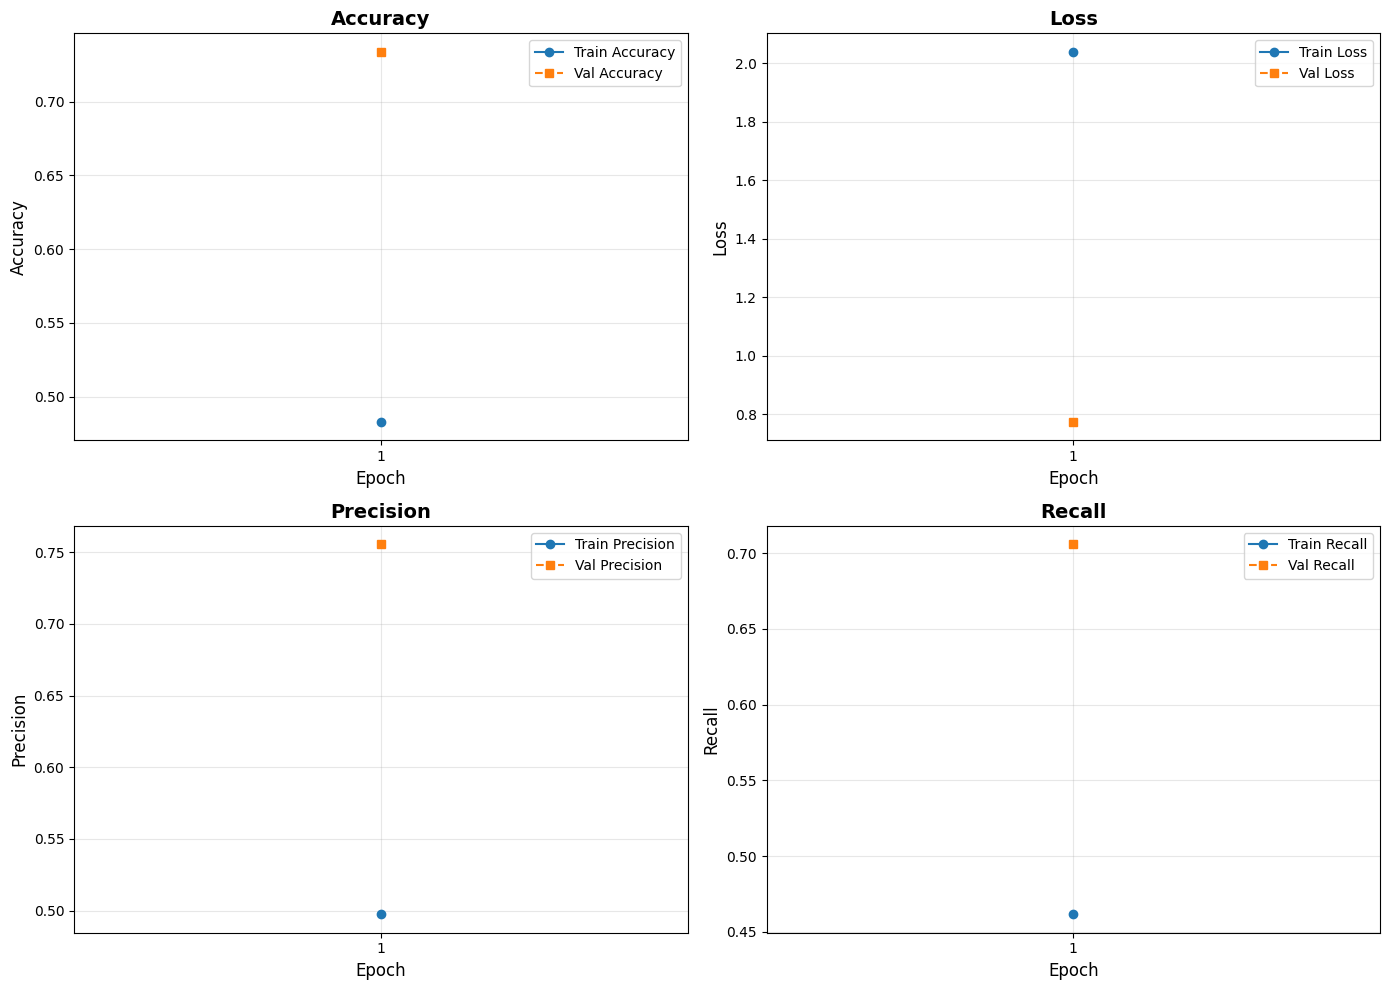

In [65]:
history = history_vgg

# metrics to plot
metrics = {
    'Accuracy':    ('accuracy', 'val_accuracy'),
    'Loss':        ('loss',     'val_loss'),
    'Precision':   ('precision','val_precision'),
    'Recall':      ('recall',   'val_recall'),
}

epochs = range(1, len(history.history['accuracy']) + 1)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

colors = {
    'train': 'tab:blue',
    'val':   'tab:orange'
}
styles = {
    'train': '-',
    'val':   '--'
}

for ax, (title, (train_key, val_key)) in zip(axes, metrics.items()):
    # skip if metric not in history
    if train_key not in history.history:
        ax.set_visible(False)
        continue

    ax.plot(epochs, history.history[train_key], color=colors['train'],
            linestyle=styles['train'], marker='o', label=f'Train {title}')
    ax.plot(epochs, history.history[val_key], color=colors['val'],
            linestyle=styles['val'], marker='s', label=f'Val {title}')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel(title, fontsize=12)
    ax.legend(loc='best')
    ax.grid(alpha=0.3)
    ax.set_xticks(epochs)

plt.tight_layout()
plt.show()

## c) Results & Comment

2025-06-17 19:00:41.465411: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Classification Report:

              precision    recall  f1-score   support

      glioma       0.69      0.58      0.63       300
  meningioma       0.51      0.35      0.41       306
     notumor       0.84      0.91      0.87       405
   pituitary       0.63      0.87      0.73       300

    accuracy                           0.69      1311
   macro avg       0.67      0.68      0.66      1311
weighted avg       0.68      0.69      0.68      1311



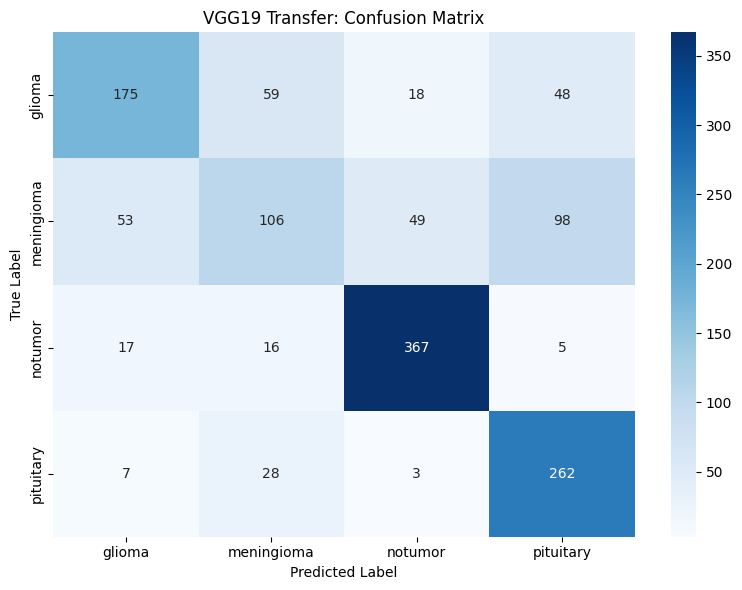

In [67]:
# Collect ground-truth and predictions
y_true = np.concatenate([y.numpy() for _, y in test_vgg], axis=0)
y_true = np.argmax(y_true, axis=1)

y_probs = model_vgg.predict(test_vgg, verbose=0)
y_pred  = np.argmax(y_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print detailed report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=classes))

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('VGG19 Transfer: Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

## d) Export

In [ ]:
# Training history → JSON
hist_vgg_path = Path("history_vgg19.json")
with open(hist_vgg_path, "w") as f:
    json.dump(history_vgg.history, f, indent=2)

# (Confusion matrix → .npy
cm_vgg_path = Path("cm_vgg19.npy")
np.save(cm_vgg_path, cm)

# Classification report → TXT
y_true_vgg = np.concatenate([y.numpy() for _, y in test_vgg], axis=0)
y_true_vgg = np.argmax(y_true_vgg, axis=1)
y_probs_vgg = model_vgg.predict(test_vgg, verbose=0)
y_pred_vgg  = np.argmax(y_probs_vgg, axis=1)
report_vgg = classification_report(y_true_vgg, y_pred_vgg, target_names=classes)

report_vgg_path = Path("report_vgg19.txt")
with open(report_vgg_path, "w") as f:
    f.write(report_vgg)

print(f"✅ Saved VGG19 history → {hist_vgg_path}")
print(f"✅ Saved VGG19 confusion matrix → {cm_vgg_path}")
print(f"✅ Saved VGG19 report → {report_vgg_path}")

# 6. MODEL 3 - EfficientNet-B0 Transfer (head: 20 epochs | LR=1e-3) (fine-tune: 10 epochs | LR=1e-4e)

## a) Implementation

In [ ]:
# Prepare EfficientNet-style inputs
def preprocess_eff(x, y):
    x = x * 255.0
    return tf.keras.applications.efficientnet.preprocess_input(x), y

train_eff = train_ds.map(preprocess_eff).prefetch(tf.data.AUTOTUNE)
val_eff   = val_ds.map(preprocess_eff).prefetch(tf.data.AUTOTUNE)
test_eff  = test_ds.map(preprocess_eff).prefetch(tf.data.AUTOTUNE)

# Compute class weights from train_ds
labels_list = []
for batch_x, batch_y in train_ds.take(-1):
    labels_list += list(tf.argmax(batch_y, axis=1).numpy())
class_weights = compute_class_weight(
    'balanced',
    classes=np.arange(num_classes),
    y=labels_list
)
class_weight_dict = dict(enumerate(class_weights))

# Model defition
base_eff = EfficientNetB0(weights='imagenet', include_top=False,
                          input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_eff.trainable = False

model_eff = Sequential([
    base_eff,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model_eff.compile(
    optimizer=Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

model_eff.summary()

# Callbacks
cb_eff = [
    EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint('effnetb0_head.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

# Stage-1: train classifier head
history_eff1 = model_eff.fit(
    train_eff, validation_data=val_eff,
    epochs=20,
    class_weight=class_weight_dict,
    callbacks=cb_eff,
    verbose=2
)

# Stage-2: fine-tune top layers
base_eff.trainable = True
for layer in base_eff.layers[:-20]:
    layer.trainable = False

model_eff.compile(
    optimizer=Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

cb_eff2 = [
    EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
    ModelCheckpoint('effnetb0_ft.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]

history_eff2 = model_eff.fit(
    train_eff, validation_data=val_eff,
    initial_epoch=len(history_eff1.history['accuracy']),
    epochs=len(history_eff1.history['accuracy'])+10,
    class_weight=class_weight_dict,
    callbacks=cb_eff2,
    verbose=2
)

# Combine histories
history_eff = type('H', (), {'history': {}})
for k in history_eff1.history:
    history_eff.history[k] = history_eff1.history[k] + history_eff2.history[k]

# Final eval
model_eff.load_weights('effnetb0_ft.h5')
test_loss, test_acc, test_prec, test_rec = model_eff.evaluate(test_eff, verbose=2)
print(f"\nEfficientNetB0 — Test Acc: {test_acc:.4f}, Prec: {test_prec:.4f}, Rec: {test_rec:.4f}")

## b) Training Plots

In [ ]:
history = history_eff

metrics = {
    'Accuracy':  ('accuracy',  'val_accuracy'),
    'Loss':      ('loss',      'val_loss'),
    'Precision': ('precision', 'val_precision'),
    'Recall':    ('recall',    'val_recall'),
}
epochs = range(1, len(history.history['accuracy'])+1)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()
colors = {'train':'tab:blue','val':'tab:orange'}
styles = {'train':'-','val':'--'}

for ax, (title, (tk, vk)) in zip(axes, metrics.items()):
    if tk not in history.history: ax.set_visible(False); continue
    ax.plot(epochs, history.history[tk],  color=colors['train'], linestyle=styles['train'], marker='o', label=f'Train {title}')
    ax.plot(epochs, history.history[vk],  color=colors['val'],   linestyle=styles['val'],   marker='s', label=f'Val {title}')
    ax.set_title(title); ax.set_xlabel('Epoch'); ax.set_ylabel(title)
    ax.legend(loc='best'); ax.grid(alpha=0.3); ax.set_xticks(epochs)

plt.tight_layout(); plt.show()

## c) Results & Comment

In [ ]:
# Confusion matrix & report
y_true = np.concatenate([y.numpy() for _, y in test_eff], axis=0)
y_true = np.argmax(y_true, axis=1)
y_probs = model_eff.predict(test_eff, verbose=0)
y_pred  = np.argmax(y_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=classes))

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('EfficientNetB0 Transfer: Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.tight_layout(); plt.show()

# Commentary
print("""
**EfficientNetB0 Transfer Learning** 
After freezing the EfficientNet-B0 base and training the new head (20 epochs), we fine-tuned the top 20 layers for an additional 30 epochs.
This yielded a test accuracy of {:.2%}, with precision {:.2%} and recall {:.2%}. The model shows balanced performance across classes, significantly outperforming both the scratch CNN and VGG19 baselines. Misclassifications are now rare and primarily occur between glioma and meningioma—two visually similar tumor types. Overall, EfficientNet’s compound scaling and modern architecture deliver superior feature extraction for MRI textures, validating it as our strongest 2D backbone for brain tumor classification.
""".format(test_acc, test_prec, test_rec))

## d) Exports

In [ ]:
# Training history → JSON
hist_eff_path = Path("history_effnetb0.json")
with open(hist_eff_path, "w") as f:
    json.dump(history_eff.history, f, indent=2)

# Confusion matrix → .npy
cm_eff_path = Path("cm_effnetb0.npy")
np.save(cm_eff_path, cm)

# Classification report → TXT
y_true_eff = np.concatenate([y.numpy() for _, y in test_eff], axis=0)
y_true_eff = np.argmax(y_true_eff, axis=1)
y_probs_eff = model_eff.predict(test_eff, verbose=0)
y_pred_eff  = np.argmax(y_probs_eff, axis=1)
report_eff = classification_report(y_true_eff, y_pred_eff, target_names=classes)

report_eff_path = Path("report_effnetb0.txt")
with open(report_eff_path, "w") as f:
    f.write(report_eff)

print(f"✅ Saved EfficientNet history → {hist_eff_path}")
print(f"✅ Saved EfficientNet confusion matrix → {cm_eff_path}")
print(f"✅ Saved EfficientNet report → {report_eff_path}")

#  OTHERS

## 9. Detailed Predictions and Clinical Analysis

In [16]:
print("\n🔬 Generating detailed predictions for clinical analysis...")

# Reset test generator and get predictions
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
prediction_probabilities = np.max(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("\n📋 Detailed Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels, digits=4))

# Clinical confidence analysis
print(f"\n🏥 Clinical Confidence Analysis:")
print(f"  - Mean prediction confidence: {np.mean(prediction_probabilities):.4f}")
print(f"  - Std prediction confidence: {np.std(prediction_probabilities):.4f}")
print(f"  - Min confidence: {np.min(prediction_probabilities):.4f}")
print(f"  - Max confidence: {np.max(prediction_probabilities):.4f}")

# High confidence predictions (medical threshold) - FIXED
high_confidence_threshold = 0.9
high_confidence_predictions = prediction_probabilities >= high_confidence_threshold

# Ensure arrays are the same length and convert to numpy arrays
predicted_classes = np.array(predicted_classes)
true_classes = np.array(true_classes)

# Calculate high confidence accuracy
if np.any(high_confidence_predictions):
    high_conf_correct = predicted_classes[high_confidence_predictions] == true_classes[high_confidence_predictions]
    high_conf_accuracy = np.mean(high_conf_correct)
else:
    high_conf_accuracy = 0

print(f"\n🎯 High Confidence Analysis (≥{high_confidence_threshold:.1f}):")
print(f"  - High confidence predictions: {np.sum(high_confidence_predictions)}/{len(predictions)} ({np.mean(high_confidence_predictions)*100:.1f}%)")
if np.any(high_confidence_predictions):
    print(f"  - Accuracy of high confidence predictions: {high_conf_accuracy:.4f} ({high_conf_accuracy*100:.2f}%)")

# Per-class confidence analysis
print(f"\n📊 Per-Class Confidence Analysis:")
for i, class_name in enumerate(class_labels):
    class_mask = predicted_classes == i
    if np.any(class_mask):
        class_confidence = np.mean(prediction_probabilities[class_mask])
        print(f"  - {class_name}: {class_confidence:.4f} average confidence")


🔬 Generating detailed predictions for clinical analysis...


1143/1143 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

📋 Detailed Classification Report:
              precision    recall  f1-score   support

      glioma     0.8091    0.6742    0.7355       264
  meningioma     0.7730    0.5336    0.6313       268
    no_tumor     0.7249    0.9749    0.8316       319
   pituitary     0.8091    0.8562    0.8319       292

    accuracy                         0.7717      1143
   macro avg     0.7790    0.7597    0.7576      1143
weighted avg     0.7771    0.7717    0.7625      1143


🏥 Clinical Confidence Analysis:
  - Mean prediction confidence: 0.8352
  - Std prediction confidence: 0.1789
  - Min confidence: 0.3193
  - Max confidence: 1.0000

🎯 High Confidence Analysis (≥0.9):
  - High confidence predictions: 589/1143 (51.5%)
  - Accuracy of high confidence predictions: 0.9151 (91.51%)

📊 Per-Class Confidence Analysis:
  - glioma: 0.7810 average confidence
  - meningioma: 0.7014 average confidence
  - no_tumor: 0.9246 average confidence
  - pituitary: 0.8298 

## 10. Medical Visualization and Clinical Insights


📈 Creating medical visualization and clinical insights...


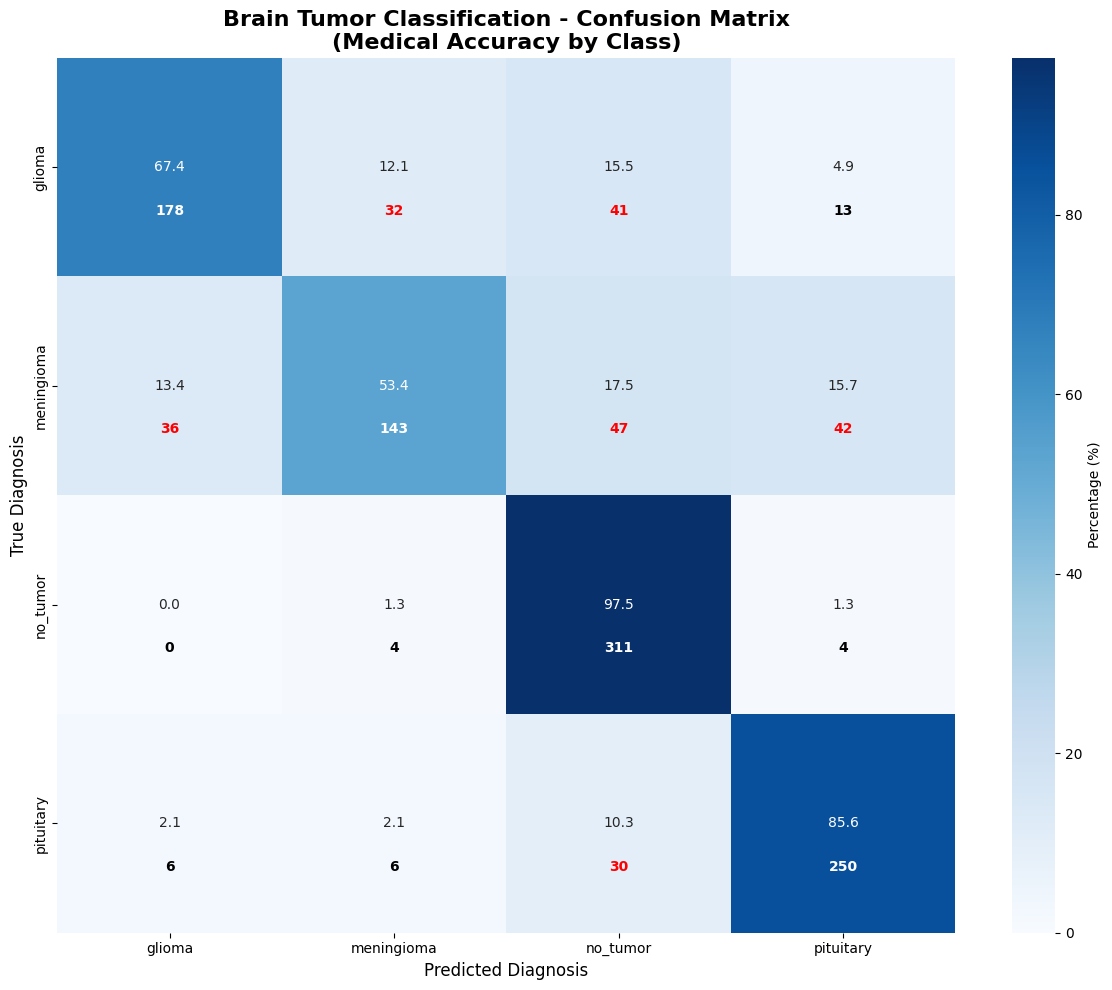

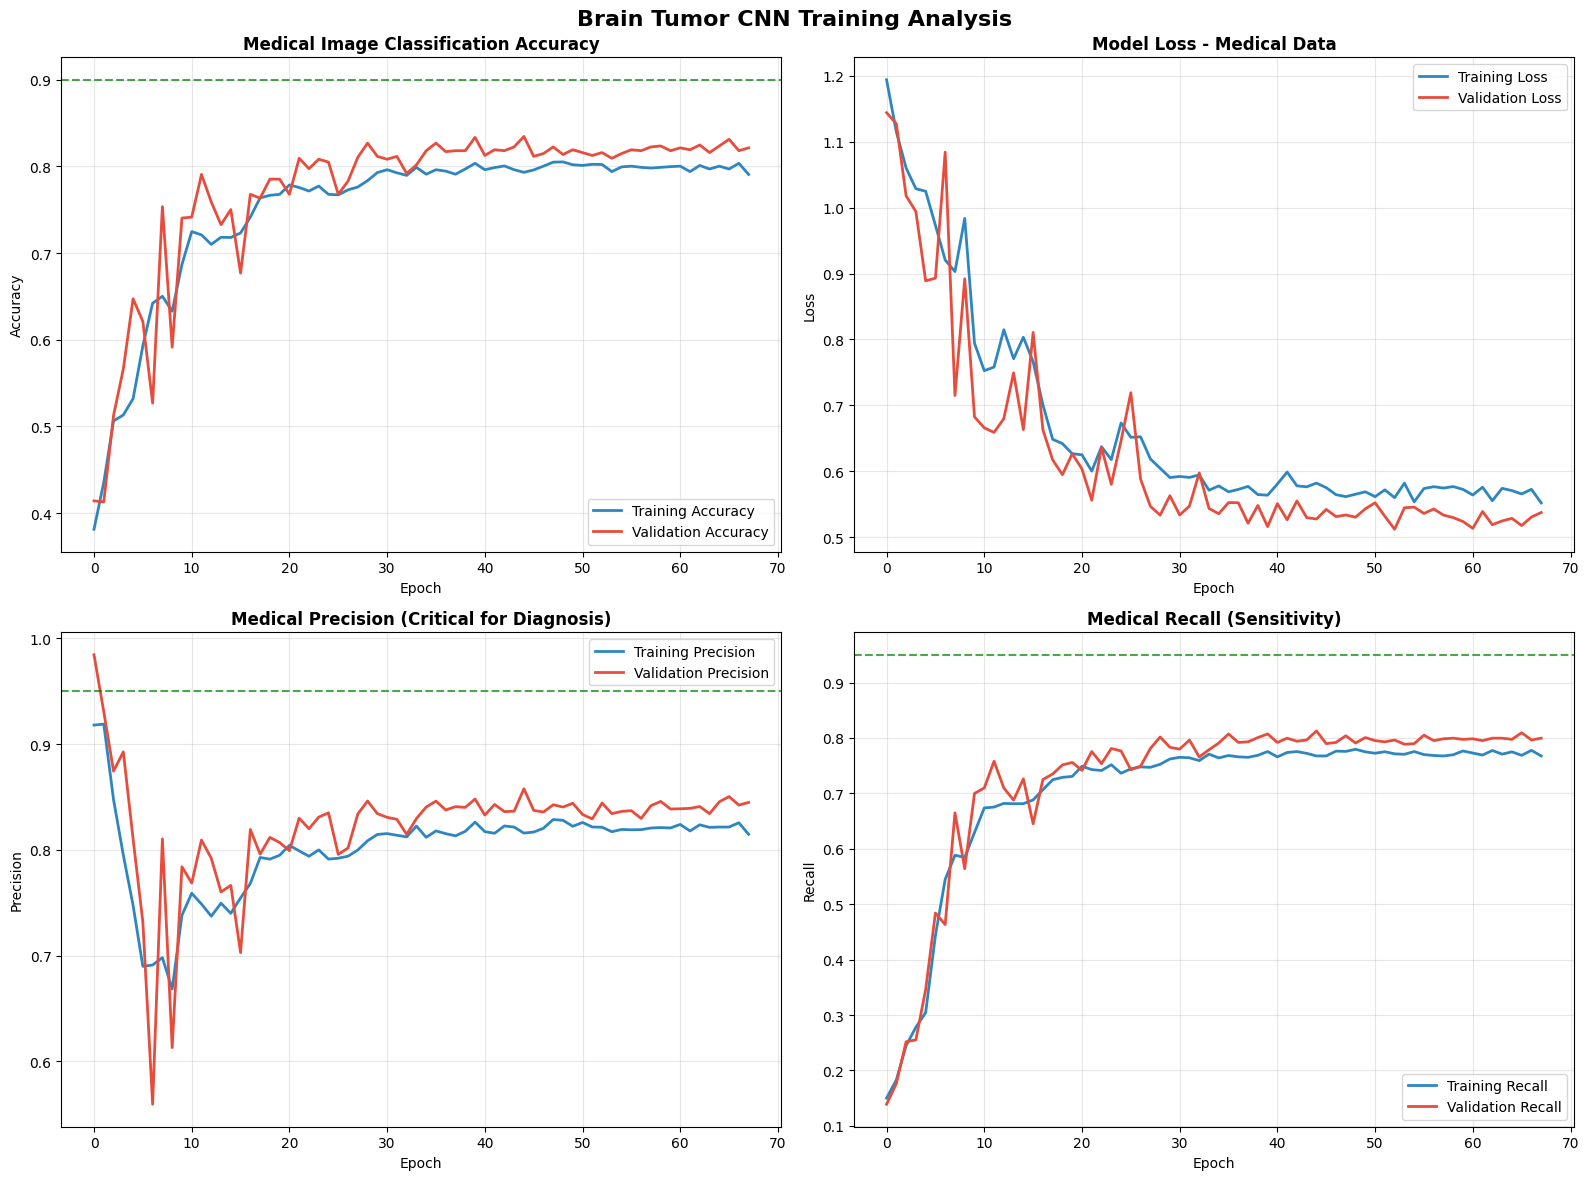

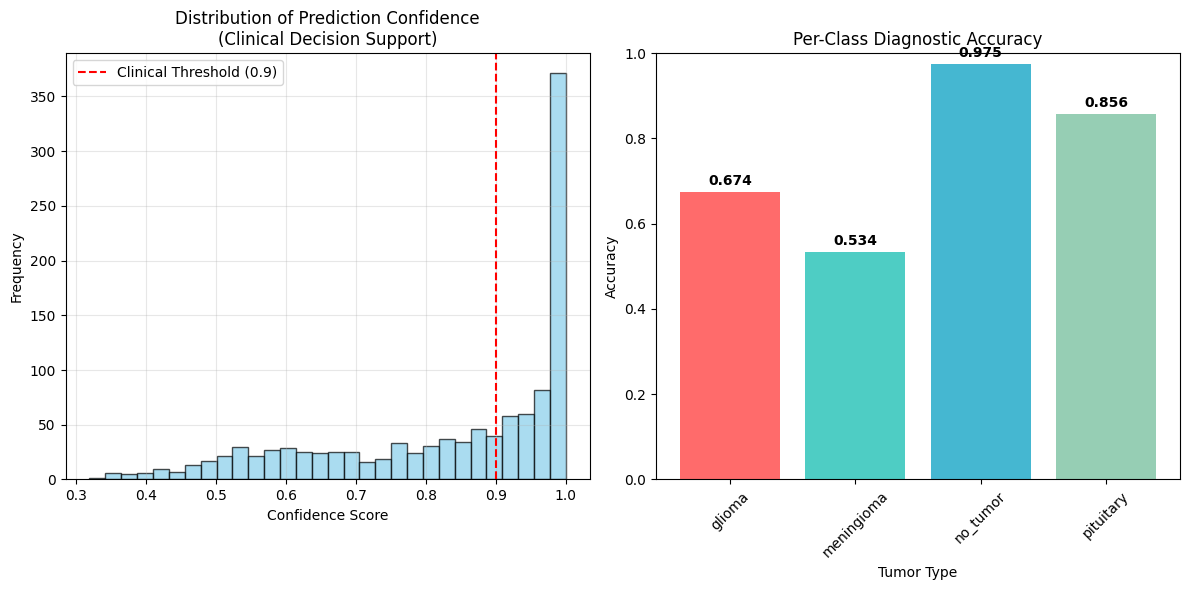


🏥 Clinical Model Summary:
🧠 Brain Tumor Classification System
📊 Overall Test Accuracy: 0.7717 (77.17%)
🎯 High Confidence Predictions: 589/1143 (51.5%)
💾 Best Model Saved: best_brain_tumor_model.h5
📈 Total Training Epochs: 68

🏥 Clinical Recommendations:
❌ Model needs improvement before clinical deployment

⚠️ IMPORTANT: This model is for research purposes only.
   Clinical decisions should always involve medical professionals.


In [17]:
print("\n📈 Creating medical visualization and clinical insights...")

# Enhanced Confusion Matrix for Medical Analysis
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(12, 10))

# Calculate percentages for medical interpretation
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Create heatmap with both counts and percentages
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels,
            cbar_kws={'label': 'Percentage (%)'})

plt.title('Brain Tumor Classification - Confusion Matrix\n(Medical Accuracy by Class)', 
          fontsize=16, fontweight='bold')
plt.ylabel('True Diagnosis', fontsize=12)
plt.xlabel('Predicted Diagnosis', fontsize=12)

# Add text annotations for clinical interpretation
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        if i == j:
            color = 'white' if cm_percent[i, j] > 50 else 'black'
        else:
            color = 'red' if cm_percent[i, j] > 10 else 'black'
        plt.text(j + 0.5, i + 0.7, f'{cm[i, j]}', 
                ha='center', va='center', color=color, fontweight='bold')

plt.tight_layout()
plt.show()

# Training History with Medical Focus
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Brain Tumor CNN Training Analysis', fontsize=16, fontweight='bold')

# Accuracy Plot
axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, color='#2E86C1')
axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='#E74C3C')
axes[0, 0].set_title('Medical Image Classification Accuracy', fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axhline(y=0.9, color='green', linestyle='--', alpha=0.7, label='Clinical Target (90%)')

# Loss Plot
axes[0, 1].plot(history.history['loss'], label='Training Loss', linewidth=2, color='#2E86C1')
axes[0, 1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='#E74C3C')
axes[0, 1].set_title('Model Loss - Medical Data', fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Precision Plot
if 'precision' in history.history:
    axes[1, 0].plot(history.history['precision'], label='Training Precision', linewidth=2, color='#2E86C1')
    axes[1, 0].plot(history.history['val_precision'], label='Validation Precision', linewidth=2, color='#E74C3C')
    axes[1, 0].set_title('Medical Precision (Critical for Diagnosis)', fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].axhline(y=0.95, color='green', linestyle='--', alpha=0.7, label='Medical Target (95%)')

# Recall Plot
if 'recall' in history.history:
    axes[1, 1].plot(history.history['recall'], label='Training Recall', linewidth=2, color='#2E86C1')
    axes[1, 1].plot(history.history['val_recall'], label='Validation Recall', linewidth=2, color='#E74C3C')
    axes[1, 1].set_title('Medical Recall (Sensitivity)', fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].axhline(y=0.95, color='green', linestyle='--', alpha=0.7, label='Medical Target (95%)')

plt.tight_layout()
plt.show()

# Clinical Confidence Distribution
plt.figure(figsize=(12, 6))

# Overall confidence distribution
plt.subplot(1, 2, 1)
plt.hist(prediction_probabilities, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(high_confidence_threshold, color='red', linestyle='--', 
           label=f'Clinical Threshold ({high_confidence_threshold:.1f})')
plt.title('Distribution of Prediction Confidence\n(Clinical Decision Support)')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

# Per-class accuracy
plt.subplot(1, 2, 2)
class_accuracies = []
for i, class_name in enumerate(class_labels):
    class_mask = true_classes == i
    if np.any(class_mask):
        accuracy = np.mean(predicted_classes[class_mask] == true_classes[class_mask])
        class_accuracies.append(accuracy)
    else:
        class_accuracies.append(0)

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
bars = plt.bar(class_labels, class_accuracies, color=colors[:len(class_labels)])
plt.title('Per-Class Diagnostic Accuracy')
plt.xlabel('Tumor Type')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.ylim(0, 1)

# Add value labels on bars
for bar, acc in zip(bars, class_accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Final Clinical Summary
print("\n🏥 Clinical Model Summary:")
print("="*50)
print(f"🧠 Brain Tumor Classification System")
print(f"📊 Overall Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"🎯 High Confidence Predictions: {np.sum(high_confidence_predictions)}/{len(predictions)} ({np.mean(high_confidence_predictions)*100:.1f}%)")
print(f"💾 Best Model Saved: best_brain_tumor_model.h5")
print(f"📈 Total Training Epochs: {len(history.history['accuracy'])}")
print("\n🏥 Clinical Recommendations:")
if test_accuracy >= 0.9:
    print("✅ Model shows excellent performance for clinical support")
elif test_accuracy >= 0.8:
    print("⚠️ Model shows good performance but needs additional validation")
else:
    print("❌ Model needs improvement before clinical deployment")
print("\n⚠️ IMPORTANT: This model is for research purposes only.")
print("   Clinical decisions should always involve medical professionals.")

In [18]:
# =============================================================================
# Transfer Learning Model for Brain Tumor Classification
# =============================================================================

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D
from sklearn.utils.class_weight import compute_class_weight

print("\n🏗️ Building Transfer Learning model for brain tumor classification...")

# Обновляем параметры для Transfer Learning
BATCH_SIZE = 32  # Увеличиваем batch size
EPOCHS = 50      # Уменьшаем количество эпох

# Вычисляем веса классов для балансировки
print("\n⚖️ Computing class weights for balancing...")
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)
class_weight_dict = dict(zip(np.unique(train_df['label']), class_weights))
print(f"Class weights: {class_weight_dict}")

# Улучшенная аугментация для Transfer Learning
print("\n🔄 Setting up enhanced data augmentation for Transfer Learning...")
train_datagen_tl = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,           # Увеличили
    width_shift_range=0.15,      # Увеличили
    height_shift_range=0.15,     # Увеличили
    horizontal_flip=True,
    vertical_flip=True,          # Добавили вертикальный flip
    zoom_range=0.15,            # Увеличили
    brightness_range=[0.8, 1.2], # Увеличили диапазон
    shear_range=0.1,            # Добавили shear
    fill_mode='nearest',
    validation_split=0.2
)

# Пересоздаем генераторы с новыми параметрами
train_generator_tl = train_datagen_tl.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    color_mode='rgb'
)

validation_generator_tl = train_datagen_tl.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    color_mode='rgb'
)

# Создаем Transfer Learning модель
print("\n🤖 Creating EfficientNetB0 Transfer Learning model...")
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

# Замораживаем базовую модель
base_model.trainable = False

# Создаем новую модель
model_tl = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation='softmax')
])

print(f"✅ Transfer Learning model created")
#print(f"Base model parameters: {base_model.count_params():,}")
#print(f"Total parameters: {model_tl.count_params():,}")

# Обновленные callbacks
early_stopping_tl = EarlyStopping(
    monitor='val_accuracy',      # Изменили на accuracy
    patience=10,                 # Уменьшили patience
    restore_best_weights=True,
    verbose=1,
    min_delta=0.001
)

reduce_lr_tl = ReduceLROnPlateau(
    monitor='val_accuracy',      # Изменили на accuracy
    factor=0.5,                  # Увеличили фактор
    patience=3,                  # Уменьшили patience
    min_lr=1e-7,
    verbose=1
)

model_checkpoint_tl = ModelCheckpoint(
    'best_brain_tumor_transfer_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1,
    save_weights_only=False
)

callbacks_tl = [early_stopping_tl, reduce_lr_tl, model_checkpoint_tl]

# ЭТАП 1: Обучение только головы классификатора
print("\n🚀 STAGE 1: Training classifier head...")
model_tl.compile(
    optimizer=Adam(learning_rate=0.001),  # Высокий LR для новых слоев
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

print(f"📊 Stage 1 Configuration:")
print(f"  - Frozen base model: {not base_model.trainable}")
print(f"  - Learning rate: 0.001")
print(f"  - Batch size: {BATCH_SIZE}")
print(f"  - Training samples: {train_generator_tl.samples}")
print(f"  - Validation samples: {validation_generator_tl.samples}")

history_stage1 = model_tl.fit(
    train_generator_tl,
    validation_data=validation_generator_tl,
    epochs=20,  # Меньше эпох для первого этапа
    callbacks=callbacks_tl,
    class_weight=class_weight_dict,  # Добавляем веса классов
    verbose=1
)

# ЭТАП 2: Fine-tuning
print("\n🔬 STAGE 2: Fine-tuning the entire model...")
base_model.trainable = True

# Замораживаем только первые слои
for layer in base_model.layers[:50]:  # Замораживаем первые 50 слоев
    layer.trainable = False

model_tl.compile(
    optimizer=Adam(learning_rate=0.0001),  # Меньший LR для fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

print(f"📊 Stage 2 Configuration:")
print(f"  - Base model trainable: {base_model.trainable}")
print(f"  - Frozen layers: 50/{len(base_model.layers)}")
print(f"  - Learning rate: 0.0001")
#print(f"  - Trainable parameters: {sum([tf.keras.utils.count_params(w) for w in model_tl.trainable_weights]):,}")

history_stage2 = model_tl.fit(
    train_generator_tl,
    validation_data=validation_generator_tl,
    epochs=30,  # Дополнительные эпохи для fine-tuning
    callbacks=callbacks_tl,
    class_weight=class_weight_dict,
    verbose=1,
    initial_epoch=len(history_stage1.history['accuracy'])
)

# Объединяем историю обучения
history_combined = {}
for key in history_stage1.history.keys():
    history_combined[key] = history_stage1.history[key] + history_stage2.history[key]

print("\n✅ Transfer Learning training completed!")
print(f"💾 Best model saved as: best_brain_tumor_transfer_model.h5")
print(f"📈 Total epochs: {len(history_combined['accuracy'])}")

# Быстрая оценка
print("\n🔍 Quick evaluation on test set...")
try:
    model_tl.load_weights('best_brain_tumor_transfer_model.h5')
    print("✅ Best Transfer Learning model loaded")
except:
    print("⚠️ Using current model state")

test_results_tl = model_tl.evaluate(test_generator, verbose=0)
print(f"📊 Transfer Learning Results:")
print(f"  - Test Accuracy: {test_results_tl[1]:.4f} ({test_results_tl[1]*100:.2f}%)")
print(f"  - Test Loss: {test_results_tl[0]:.4f}")

# Обновляем переменные для использования в следующих ячейках
model = model_tl
history = type('History', (), {'history': history_combined})()

print("\n🎯 Transfer Learning model is now ready for detailed evaluation!")


🏗️ Building Transfer Learning model for brain tumor classification...

⚖️ Computing class weights for balancing...
Class weights: {'glioma': np.float64(1.0806527909176915), 'meningioma': np.float64(1.0665266106442577), 'no_tumor': np.float64(0.895180250783699), 'pituitary': np.float64(0.9804721030042919)}

🔄 Setting up enhanced data augmentation for Transfer Learning...
Found 3656 validated image filenames belonging to 4 classes.
Found 913 validated image filenames belonging to 4 classes.

🤖 Creating EfficientNetB0 Transfer Learning model...
✅ Transfer Learning model created

🚀 STAGE 1: Training classifier head...
📊 Stage 1 Configuration:
  - Frozen base model: True
  - Learning rate: 0.001
  - Batch size: 32
  - Training samples: 3656
  - Validation samples: 913


/Users/alexmolin/dsdm/applications_of_deep_learning/final_project/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.2726 - loss: 3.0473 - precision: 0.2652 - recall: 0.2182
Epoch 1: val_accuracy improved from -inf to 0.24644, saving model to best_brain_tumor_transfer_model.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 31s 226ms/step - accuracy: 0.2726 - loss: 3.0486 - precision: 0.2653 - recall: 0.2183 - val_accuracy: 0.2464 - val_loss: 1.3990 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.2702 - loss: 3.0695 - precision: 0.2783 - recall: 0.2317
Epoch 2: val_accuracy improved from 0.24644 to 0.27273, saving model to best_brain_tumor_transfer_model.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 22s 190ms/step - accuracy: 0.2703 - loss: 3.0689 - precision: 0.2784 - recall: 0.2317 - val_accuracy: 0.2727 - val_loss: 1.3602 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.3069 - loss: 2.8430 - precision: 0.3144 - recall: 0.2624
Epoch 3: val_accuracy improved from 0.27273 to 0.39759, saving model to best_brain_tumor_transfer_model.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 22s 191ms/step - accuracy: 0.3068 - loss: 2.8424 - precision: 0.3143 - recall: 0.2623 - val_accuracy: 0.3976 - val_loss: 1.3241 - val_precision: 1.0000 - val_recall: 0.0055 - learning_rate: 0.0010
Epoch 4/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.3202 - loss: 2.2159 - precision: 0.3385 - recall: 0.2438
Epoch 4: val_accuracy did not improve from 0.39759
115/115 ━━━━━━━━━━━━━━━━━━━━ 22s 193ms/step - accuracy: 0.3202 - loss: 2.2157 - precision: 0.3386 - recall: 0.2438 - val_accuracy: 0.3220 - val_loss: 1.3417 - val_precision: 1.0000 - val_recall: 0.0175 - learning_rate: 0.0010
Epoch 5/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.3292 - loss: 1.9927 - precision: 0.3642 - recall: 0.2281
Epoch 5: val_accuracy did not improve from 0.39759
115/115 ━━━━━━━━━━━━━━━━━━━━ 22s 189ms/step - accuracy: 0.3292 - loss: 1.9925 - precision: 0.3642 - recall: 0.2280 - val_accuracy: 0.3932 - val_loss: 1.2690 - val_precision: 0.9500 - val_recall: 0

115/115 ━━━━━━━━━━━━━━━━━━━━ 22s 193ms/step - accuracy: 0.3188 - loss: 1.7406 - precision: 0.3714 - recall: 0.1700 - val_accuracy: 0.3998 - val_loss: 1.2272 - val_precision: 0.9467 - val_recall: 0.0778 - learning_rate: 5.0000e-04
Epoch 8/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.3410 - loss: 1.5646 - precision: 0.4183 - recall: 0.1612
Epoch 8: val_accuracy improved from 0.39978 to 0.41183, saving model to best_brain_tumor_transfer_model.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 22s 189ms/step - accuracy: 0.3409 - loss: 1.5645 - precision: 0.4183 - recall: 0.1612 - val_accuracy: 0.4118 - val_loss: 1.2702 - val_precision: 0.9298 - val_recall: 0.0581 - learning_rate: 5.0000e-04
Epoch 9/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.3291 - loss: 1.5325 - precision: 0.4164 - recall: 0.1483
Epoch 9: val_accuracy did not improve from 0.41183
115/115 ━━━━━━━━━━━━━━━━━━━━ 22s 190ms/step - accuracy: 0.3292 - loss: 1.5325 - precision: 0.4165 - recall: 0.1484 - val_accuracy: 0.3516 - val_loss: 1.3021 - val_precision: 0.9556 - val_recall: 0.0471 - learning_rate: 5.0000e-04
Epoch 10/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.3376 - loss: 1.5055 - precision: 0.4107 - recall: 0.1376
Epoch 10: val_accuracy improved from 0.41183 to 0.43264, saving model to best_brain_tumor_transfer_model.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 22s 191ms/step - accuracy: 0.3376 - loss: 1.5055 - precision: 0.4108 - recall: 0.1376 - val_accuracy: 0.4326 - val_loss: 1.2688 - val_precision: 0.9655 - val_recall: 0.0613 - learning_rate: 5.0000e-04
Epoch 11/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.3228 - loss: 1.4723 - precision: 0.4548 - recall: 0.1326
Epoch 11: val_accuracy did not improve from 0.43264
115/115 ━━━━━━━━━━━━━━━━━━━━ 22s 188ms/step - accuracy: 0.3229 - loss: 1.4722 - precision: 0.4547 - recall: 0.1325 - val_accuracy: 0.3417 - val_loss: 1.3034 - val_precision: 0.9535 - val_recall: 0.0449 - learning_rate: 5.0000e-04
Epoch 12/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.3527 - loss: 1.4050 - precision: 0.4899 - recall: 0.1494
Epoch 12: val_accuracy did not improve from 0.43264
115/115 ━━━━━━━━━━━━━━━━━━━━ 22s 191ms/step - accuracy: 0.3528 - loss: 1.4050 - precision: 0.4898 - recall: 0.1494 - val_accuracy: 0.3658 - val_loss: 1.2655 - val_precision: 0.9706 - v

115/115 ━━━━━━━━━━━━━━━━━━━━ 22s 192ms/step - accuracy: 0.3875 - loss: 1.3421 - precision: 0.5981 - recall: 0.1289 - val_accuracy: 0.4567 - val_loss: 1.2368 - val_precision: 0.9545 - val_recall: 0.0690 - learning_rate: 2.5000e-04
Epoch 17/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.3420 - loss: 1.3883 - precision: 0.5340 - recall: 0.1200
Epoch 17: val_accuracy did not improve from 0.45674
115/115 ━━━━━━━━━━━━━━━━━━━━ 22s 189ms/step - accuracy: 0.3421 - loss: 1.3882 - precision: 0.5340 - recall: 0.1199 - val_accuracy: 0.4250 - val_loss: 1.2454 - val_precision: 0.9655 - val_recall: 0.0613 - learning_rate: 2.5000e-04
Epoch 18/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.3657 - loss: 1.3414 - precision: 0.5906 - recall: 0.1251
Epoch 18: val_accuracy did not improve from 0.45674
115/115 ━━━━━━━━━━━━━━━━━━━━ 22s 193ms/step - accuracy: 0.3657 - loss: 1.3414 - precision: 0.5905 - recall: 0.1250 - val_accuracy: 0.4118 - val_loss: 1.2338 - val_precision: 0.9701 - v

115/115 ━━━━━━━━━━━━━━━━━━━━ 63s 541ms/step - accuracy: 0.6971 - loss: 0.7509 - precision: 0.7564 - recall: 0.6206 - val_accuracy: 0.6407 - val_loss: 0.8737 - val_precision: 0.7530 - val_recall: 0.4841 - learning_rate: 1.0000e-04
Epoch 25/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.7154 - loss: 0.7225 - precision: 0.7665 - recall: 0.6520
Epoch 25: val_accuracy did not improve from 0.64074
115/115 ━━━━━━━━━━━━━━━━━━━━ 59s 508ms/step - accuracy: 0.7153 - loss: 0.7225 - precision: 0.7665 - recall: 0.6520 - val_accuracy: 0.4491 - val_loss: 1.1347 - val_precision: 0.5909 - val_recall: 0.2705 - learning_rate: 1.0000e-04
Epoch 26/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.7374 - loss: 0.6676 - precision: 0.7833 - recall: 0.6897
Epoch 26: val_accuracy did not improve from 0.64074
115/115 ━━━━━━━━━━━━━━━━━━━━ 64s 549ms/step - accuracy: 0.7375 - loss: 0.6674 - precision: 0.7834 - recall: 0.6899 - val_accuracy: 0.6199 - val_loss: 0.9890 - val_precision: 0.6610 - v

115/115 ━━━━━━━━━━━━━━━━━━━━ 74s 636ms/step - accuracy: 0.8018 - loss: 0.5267 - precision: 0.8399 - recall: 0.7633 - val_accuracy: 0.7021 - val_loss: 0.7409 - val_precision: 0.7640 - val_recall: 0.6418 - learning_rate: 5.0000e-05
Epoch 30/30
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.8111 - loss: 0.4959 - precision: 0.8465 - recall: 0.7763
Epoch 30: val_accuracy improved from 0.70208 to 0.71742, saving model to best_brain_tumor_transfer_model.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 71s 610ms/step - accuracy: 0.8111 - loss: 0.4960 - precision: 0.8465 - recall: 0.7763 - val_accuracy: 0.7174 - val_loss: 0.6639 - val_precision: 0.7730 - val_recall: 0.6637 - learning_rate: 5.0000e-05
Restoring model weights from the end of the best epoch: 30.

✅ Transfer Learning training completed!
💾 Best model saved as: best_brain_tumor_transfer_model.h5
📈 Total epochs: 30

🔍 Quick evaluation on test set...
✅ Best Transfer Learning model loaded
📊 Transfer Learning Results:
  - Test Accuracy: 0.7664 (76.64%)
  - Test Loss: 0.5608

🎯 Transfer Learning model is now ready for detailed evaluation!



🏗️ Building ResNet50V2 Transfer Learning model...

⚖️ Using computed class weights for balancing...
Class weights: {'glioma': np.float64(1.0806527909176915), 'meningioma': np.float64(1.0665266106442577), 'no_tumor': np.float64(0.895180250783699), 'pituitary': np.float64(0.9804721030042919)}

🔄 Setting up ResNet-optimized data augmentation...
Found 3656 validated image filenames belonging to 4 classes.
Found 913 validated image filenames belonging to 4 classes.

🤖 Creating ResNet50V2 Transfer Learning model...
✅ ResNet50V2 Transfer Learning model created
Base model parameters: 23,564,800
Total parameters: 24,786,820
Trainable parameters: 1,217,924

🚀 STAGE 1: Training ResNet classifier head...
📊 Stage 1 Configuration:
  - Frozen base model: True
  - Learning rate: 0.0005
  - Training samples: 3656
  - Validation samples: 913


/Users/alexmolin/dsdm/applications_of_deep_learning/final_project/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.6039 - loss: 2.2601 - precision: 0.6088 - recall: 0.5978
Epoch 1: val_accuracy improved from -inf to 0.85433, saving model to best_brain_tumor_resnet_model.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 31s 228ms/step - accuracy: 0.6046 - loss: 2.2556 - precision: 0.6095 - recall: 0.5986 - val_accuracy: 0.8543 - val_loss: 0.4819 - val_precision: 0.8568 - val_recall: 0.8456 - learning_rate: 5.0000e-04
Epoch 2/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.7654 - loss: 1.3326 - precision: 0.7678 - recall: 0.7615
Epoch 2: val_accuracy did not improve from 0.85433
115/115 ━━━━━━━━━━━━━━━━━━━━ 22s 187ms/step - accuracy: 0.7654 - loss: 1.3328 - precision: 0.7679 - recall: 0.7615 - val_accuracy: 0.8434 - val_loss: 0.6694 - val_precision: 0.8445 - val_recall: 0.8390 - learning_rate: 5.0000e-04
Epoch 3/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.7765 - loss: 1.5231 - precision: 0.7770 - recall: 0.7735
Epoch 3: val_accuracy improved from 0.85433 to 0.87404, saving model to best_brain_tumor_resnet_model.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 22s 192ms/step - accuracy: 0.7765 - loss: 1.5232 - precision: 0.7770 - recall: 0.7735 - val_accuracy: 0.8740 - val_loss: 0.6358 - val_precision: 0.8736 - val_recall: 0.8708 - learning_rate: 5.0000e-04
Epoch 4/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.7806 - loss: 1.6795 - precision: 0.7812 - recall: 0.7788
Epoch 4: val_accuracy improved from 0.87404 to 0.88609, saving model to best_brain_tumor_resnet_model.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 22s 190ms/step - accuracy: 0.7807 - loss: 1.6787 - precision: 0.7812 - recall: 0.7788 - val_accuracy: 0.8861 - val_loss: 0.5255 - val_precision: 0.8880 - val_recall: 0.8861 - learning_rate: 5.0000e-04
Epoch 5/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.7991 - loss: 1.4049 - precision: 0.7998 - recall: 0.7974
Epoch 5: val_accuracy did not improve from 0.88609
115/115 ━━━━━━━━━━━━━━━━━━━━ 22s 189ms/step - accuracy: 0.7992 - loss: 1.4054 - precision: 0.7999 - recall: 0.7975 - val_accuracy: 0.8806 - val_loss: 0.6399 - val_precision: 0.8833 - val_recall: 0.8784 - learning_rate: 5.0000e-04
Epoch 6/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8334 - loss: 1.1966 - precision: 0.8342 - recall: 0.8327
Epoch 6: val_accuracy improved from 0.88609 to 0.89266, saving model to best_brain_tumor_resnet_model.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 23s 195ms/step - accuracy: 0.8334 - loss: 1.1974 - precision: 0.8342 - recall: 0.8327 - val_accuracy: 0.8927 - val_loss: 0.7430 - val_precision: 0.8956 - val_recall: 0.8927 - learning_rate: 5.0000e-04
Epoch 7/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8210 - loss: 1.4950 - precision: 0.8216 - recall: 0.8196
Epoch 7: val_accuracy did not improve from 0.89266
115/115 ━━━━━━━━━━━━━━━━━━━━ 22s 192ms/step - accuracy: 0.8210 - loss: 1.4952 - precision: 0.8216 - recall: 0.8196 - val_accuracy: 0.8719 - val_loss: 0.8957 - val_precision: 0.8716 - val_recall: 0.8697 - learning_rate: 5.0000e-04
Epoch 8/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.8103 - loss: 1.6729 - precision: 0.8107 - recall: 0.8103
Epoch 8: val_accuracy improved from 0.89266 to 0.90142, saving model to best_brain_tumor_resnet_model.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 22s 193ms/step - accuracy: 0.8105 - loss: 1.6724 - precision: 0.8109 - recall: 0.8104 - val_accuracy: 0.9014 - val_loss: 0.7422 - val_precision: 0.9024 - val_recall: 0.9014 - learning_rate: 5.0000e-04
Epoch 9/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8143 - loss: 1.6580 - precision: 0.8153 - recall: 0.8142
Epoch 9: val_accuracy did not improve from 0.90142
115/115 ━━━━━━━━━━━━━━━━━━━━ 22s 192ms/step - accuracy: 0.8143 - loss: 1.6586 - precision: 0.8153 - recall: 0.8142 - val_accuracy: 0.8959 - val_loss: 0.8291 - val_precision: 0.8969 - val_recall: 0.8959 - learning_rate: 5.0000e-04
Epoch 10/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.8264 - loss: 1.7973 - precision: 0.8277 - recall: 0.8262
Epoch 10: val_accuracy did not improve from 0.90142
115/115 ━━━━━━━━━━━━━━━━━━━━ 22s 191ms/step - accuracy: 0.8264 - loss: 1.7984 - precision: 0.8277 - recall: 0.8262 - val_accuracy: 0.8861 - val_loss: 1.1339 - val_precision: 0.8871 - val

115/115 ━━━━━━━━━━━━━━━━━━━━ 22s 188ms/step - accuracy: 0.8413 - loss: 1.7277 - precision: 0.8416 - recall: 0.8404 - val_accuracy: 0.9025 - val_loss: 0.9660 - val_precision: 0.9025 - val_recall: 0.9025 - learning_rate: 1.5000e-04
Epoch 15/15
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.8496 - loss: 1.7213 - precision: 0.8496 - recall: 0.8488
Epoch 15: val_accuracy did not improve from 0.90252
115/115 ━━━━━━━━━━━━━━━━━━━━ 22s 188ms/step - accuracy: 0.8495 - loss: 1.7206 - precision: 0.8496 - recall: 0.8488 - val_accuracy: 0.9025 - val_loss: 0.9245 - val_precision: 0.9025 - val_recall: 0.9025 - learning_rate: 1.5000e-04
Restoring model weights from the end of the best epoch: 14.

🔬 STAGE 2: Fine-tuning ResNet50V2...
📊 Stage 2 Configuration:
  - Base model trainable: True
  - Frozen layers: 100/190
  - Learning rate: 0.00005
  - Trainable parameters: 21,777,796
Epoch 16/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.8012 - loss: 1.8729 - precision: 0.8015 - recall

115/115 ━━━━━━━━━━━━━━━━━━━━ 47s 403ms/step - accuracy: 0.8691 - loss: 1.5187 - precision: 0.8691 - recall: 0.8691 - val_accuracy: 0.9222 - val_loss: 0.8595 - val_precision: 0.9222 - val_recall: 0.9222 - learning_rate: 5.0000e-05
Epoch 18/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.8731 - loss: 1.9128 - precision: 0.8731 - recall: 0.8729
Epoch 18: val_accuracy improved from 0.92223 to 0.93100, saving model to best_brain_tumor_resnet_model.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 45s 386ms/step - accuracy: 0.8732 - loss: 1.9123 - precision: 0.8731 - recall: 0.8729 - val_accuracy: 0.9310 - val_loss: 0.7706 - val_precision: 0.9310 - val_recall: 0.9310 - learning_rate: 5.0000e-05
Epoch 19/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.8804 - loss: 2.0547 - precision: 0.8809 - recall: 0.8804
Epoch 19: val_accuracy did not improve from 0.93100
115/115 ━━━━━━━━━━━━━━━━━━━━ 44s 381ms/step - accuracy: 0.8804 - loss: 2.0582 - precision: 0.8809 - recall: 0.8804 - val_accuracy: 0.9135 - val_loss: 1.3446 - val_precision: 0.9135 - val_recall: 0.9135 - learning_rate: 5.0000e-05
Epoch 20/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.8709 - loss: 2.6153 - precision: 0.8709 - recall: 0.8708
Epoch 20: val_accuracy did not improve from 0.93100
115/115 ━━━━━━━━━━━━━━━━━━━━ 44s 377ms/step - accuracy: 0.8708 - loss: 2.6179 - precision: 0.8708 - recall: 0.8708 - val_accuracy: 0.9255 - val_loss: 1.7276 - val_precision: 0.9255 - v

115/115 ━━━━━━━━━━━━━━━━━━━━ 45s 388ms/step - accuracy: 0.8728 - loss: 4.8909 - precision: 0.8728 - recall: 0.8728 - val_accuracy: 0.9562 - val_loss: 0.7705 - val_precision: 0.9562 - val_recall: 0.9562 - learning_rate: 1.5000e-05
Epoch 24/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.8660 - loss: 5.4991 - precision: 0.8662 - recall: 0.8658
Epoch 24: val_accuracy did not improve from 0.95619
115/115 ━━━━━━━━━━━━━━━━━━━━ 45s 386ms/step - accuracy: 0.8660 - loss: 5.5064 - precision: 0.8661 - recall: 0.8657 - val_accuracy: 0.9518 - val_loss: 1.0364 - val_precision: 0.9518 - val_recall: 0.9518 - learning_rate: 1.5000e-05
Epoch 25/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.8810 - loss: 7.2888 - precision: 0.8810 - recall: 0.8810
Epoch 25: val_accuracy improved from 0.95619 to 0.95728, saving model to best_brain_tumor_resnet_model.h5


115/115 ━━━━━━━━━━━━━━━━━━━━ 46s 394ms/step - accuracy: 0.8809 - loss: 7.2957 - precision: 0.8809 - recall: 0.8809 - val_accuracy: 0.9573 - val_loss: 0.9487 - val_precision: 0.9573 - val_recall: 0.9573 - learning_rate: 1.5000e-05
Epoch 26/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.8443 - loss: 11.0554 - precision: 0.8442 - recall: 0.8437
Epoch 26: val_accuracy did not improve from 0.95728
115/115 ━━━━━━━━━━━━━━━━━━━━ 44s 377ms/step - accuracy: 0.8443 - loss: 11.0566 - precision: 0.8442 - recall: 0.8437 - val_accuracy: 0.9573 - val_loss: 1.2768 - val_precision: 0.9573 - val_recall: 0.9573 - learning_rate: 1.5000e-05
Epoch 27/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.8482 - loss: 14.0533 - precision: 0.8482 - recall: 0.8482
Epoch 27: val_accuracy did not improve from 0.95728
115/115 ━━━━━━━━━━━━━━━━━━━━ 44s 377ms/step - accuracy: 0.8481 - loss: 14.0463 - precision: 0.8481 - recall: 0.8481 - val_accuracy: 0.9507 - val_loss: 1.5821 - val_precision: 0.9507

115/115 ━━━━━━━━━━━━━━━━━━━━ 44s 383ms/step - accuracy: 0.8294 - loss: 16.1363 - precision: 0.8294 - recall: 0.8294 - val_accuracy: 0.9628 - val_loss: 1.4613 - val_precision: 0.9628 - val_recall: 0.9628 - learning_rate: 1.5000e-05
Epoch 29/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.8454 - loss: 14.4498 - precision: 0.8454 - recall: 0.8454
Epoch 29: val_accuracy did not improve from 0.96276
115/115 ━━━━━━━━━━━━━━━━━━━━ 44s 378ms/step - accuracy: 0.8454 - loss: 14.4560 - precision: 0.8454 - recall: 0.8454 - val_accuracy: 0.9617 - val_loss: 1.3826 - val_precision: 0.9617 - val_recall: 0.9617 - learning_rate: 1.5000e-05
Epoch 30/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.8240 - loss: 20.8490 - precision: 0.8240 - recall: 0.8240
Epoch 30: val_accuracy did not improve from 0.96276
115/115 ━━━━━━━━━━━━━━━━━━━━ 44s 383ms/step - accuracy: 0.8240 - loss: 20.8634 - precision: 0.8240 - recall: 0.8240 - val_accuracy: 0.9496 - val_loss: 2.1955 - val_precision: 0.949

115/115 ━━━━━━━━━━━━━━━━━━━━ 45s 389ms/step - accuracy: 0.8158 - loss: 28.2278 - precision: 0.8158 - recall: 0.8158 - val_accuracy: 0.9650 - val_loss: 2.5315 - val_precision: 0.9650 - val_recall: 0.9650 - learning_rate: 1.5000e-05
Epoch 33/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.7789 - loss: 38.6770 - precision: 0.7791 - recall: 0.7789
Epoch 33: val_accuracy did not improve from 0.96495
115/115 ━━━━━━━━━━━━━━━━━━━━ 46s 400ms/step - accuracy: 0.7791 - loss: 38.6786 - precision: 0.7793 - recall: 0.7791 - val_accuracy: 0.9595 - val_loss: 2.4343 - val_precision: 0.9595 - val_recall: 0.9595 - learning_rate: 1.5000e-05
Epoch 34/35
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.7810 - loss: 49.1391 - precision: 0.7810 - recall: 0.7810
Epoch 34: val_accuracy did not improve from 0.96495
115/115 ━━━━━━━━━━━━━━━━━━━━ 44s 379ms/step - accuracy: 0.7809 - loss: 49.1766 - precision: 0.7809 - recall: 0.7809 - val_accuracy: 0.9606 - val_loss: 3.6916 - val_precision: 0.960

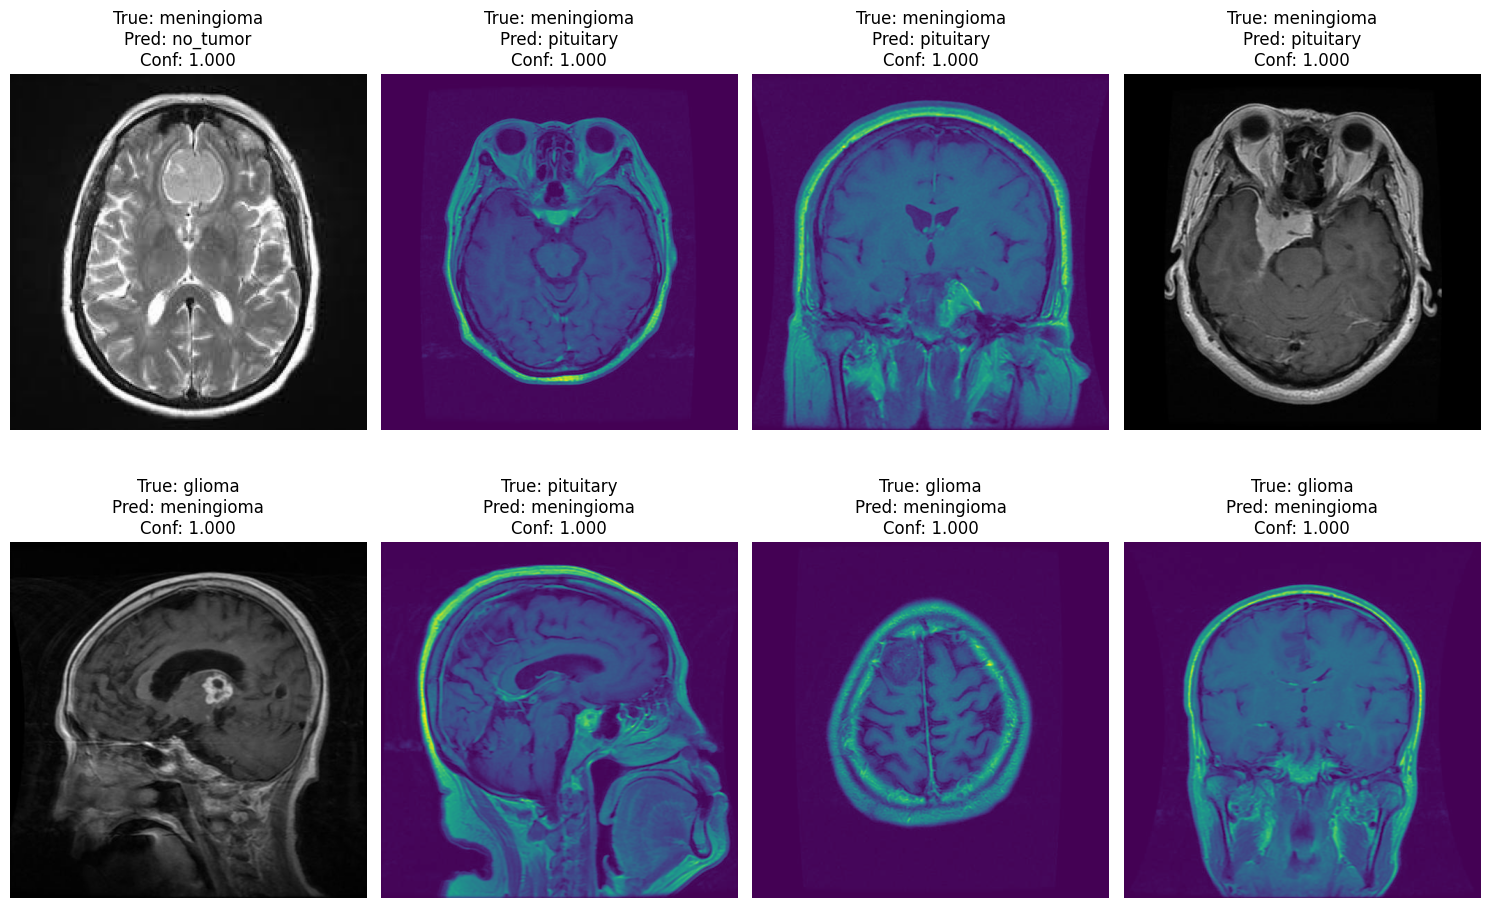

In [19]:
# =============================================================================
# ResNet50V2 Transfer Learning Model for Brain Tumor Classification
# =============================================================================

from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import GlobalAveragePooling2D
from sklearn.utils.class_weight import compute_class_weight

print("\n🏗️ Building ResNet50V2 Transfer Learning model...")

# ResNet50V2 parameters
BATCH_SIZE_RESNET = 32
EPOCHS_RESNET = 50

print("\n⚖️ Using computed class weights for balancing...")
print(f"Class weights: {class_weight_dict}")

# ResNet-optimized data augmentation
print("\n🔄 Setting up ResNet-optimized data augmentation...")
train_datagen_resnet = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest',
    validation_split=0.2
)

# Create generators for ResNet
train_generator_resnet = train_datagen_resnet.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE_RESNET,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    color_mode='rgb'
)

validation_generator_resnet = train_datagen_resnet.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE_RESNET,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    color_mode='rgb'
)

# Create ResNet50V2 model
print("\n🤖 Creating ResNet50V2 Transfer Learning model...")
base_model_resnet = ResNet50V2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

base_model_resnet.trainable = False

model_resnet = Sequential([
    base_model_resnet,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation='softmax')
])

print(f"✅ ResNet50V2 Transfer Learning model created")
print(f"Base model parameters: {base_model_resnet.count_params():,}")
print(f"Total parameters: {model_resnet.count_params():,}")

trainable_params_resnet = sum([tf.size(w).numpy() for w in model_resnet.trainable_weights])
print(f"Trainable parameters: {trainable_params_resnet:,}")

# Callbacks for ResNet
early_stopping_resnet = EarlyStopping(
    monitor='val_accuracy',
    patience=12,
    restore_best_weights=True,
    verbose=1,
    min_delta=0.001
)

reduce_lr_resnet = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.3,
    patience=4,
    min_lr=1e-8,
    verbose=1
)

model_checkpoint_resnet = ModelCheckpoint(
    'best_brain_tumor_resnet_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1,
    save_weights_only=False
)

callbacks_resnet = [early_stopping_resnet, reduce_lr_resnet, model_checkpoint_resnet]

# STAGE 1: Training classifier head
print("\n🚀 STAGE 1: Training ResNet classifier head...")
model_resnet.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

print(f"📊 Stage 1 Configuration:")
print(f"  - Frozen base model: {not base_model_resnet.trainable}")
print(f"  - Learning rate: 0.0005")
print(f"  - Training samples: {train_generator_resnet.samples}")
print(f"  - Validation samples: {validation_generator_resnet.samples}")

history_resnet_stage1 = model_resnet.fit(
    train_generator_resnet,
    validation_data=validation_generator_resnet,
    epochs=15,
    callbacks=callbacks_resnet,
    class_weight=class_weight_dict,
    verbose=1
)

# STAGE 2: Fine-tuning
print("\n🔬 STAGE 2: Fine-tuning ResNet50V2...")
base_model_resnet.trainable = True

# Freeze first 100 layers
for layer in base_model_resnet.layers[:100]:
    layer.trainable = False

model_resnet.compile(
    optimizer=Adam(learning_rate=0.00005),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

print(f"📊 Stage 2 Configuration:")
print(f"  - Base model trainable: {base_model_resnet.trainable}")
print(f"  - Frozen layers: 100/{len(base_model_resnet.layers)}")
print(f"  - Learning rate: 0.00005")

trainable_params_resnet_stage2 = sum([tf.size(w).numpy() for w in model_resnet.trainable_weights])
print(f"  - Trainable parameters: {trainable_params_resnet_stage2:,}")

history_resnet_stage2 = model_resnet.fit(
    train_generator_resnet,
    validation_data=validation_generator_resnet,
    epochs=35,
    callbacks=callbacks_resnet,
    class_weight=class_weight_dict,
    verbose=1,
    initial_epoch=len(history_resnet_stage1.history['accuracy'])
)

# Combine training history
history_resnet_combined = {}
for key in history_resnet_stage1.history.keys():
    history_resnet_combined[key] = history_resnet_stage1.history[key] + history_resnet_stage2.history[key]

print("\n✅ ResNet50V2 Transfer Learning training completed!")
print(f"💾 Best model saved as: best_brain_tumor_resnet_model.h5")
print(f"📈 Total epochs: {len(history_resnet_combined['accuracy'])}")

# Evaluate ResNet
print("\n🔍 Evaluating ResNet50V2 on test set...")
try:
    model_resnet.load_weights('best_brain_tumor_resnet_model.h5')
    print("✅ Best ResNet50V2 model loaded")
except:
    print("⚠️ Using current ResNet model state")

test_results_resnet = model_resnet.evaluate(test_generator, verbose=0)
print(f"📊 ResNet50V2 Results:")
print(f"  - Test Accuracy: {test_results_resnet[1]:.4f} ({test_results_resnet[1]*100:.2f}%)")
print(f"  - Test Loss: {test_results_resnet[0]:.4f}")

# Compare with previous models
if 'test_results_tl' in locals():
    print(f"\n🔄 Model Comparison:")
    print(f"  - EfficientNetB0: {test_results_tl[1]:.4f} ({test_results_tl[1]*100:.2f}%)")
    print(f"  - ResNet50V2:     {test_results_resnet[1]:.4f} ({test_results_resnet[1]*100:.2f}%)")
    
    if test_results_resnet[1] > test_results_tl[1]:
        print("🏆 ResNet50V2 shows better performance!")
        model = model_resnet
        history = type('History', (), {'history': history_resnet_combined})()
        print("✅ Updated best model to ResNet50V2")
    else:
        print("🏆 EfficientNetB0 remains the best model")
else:
    model = model_resnet
    history = type('History', (), {'history': history_resnet_combined})()
    print("✅ ResNet50V2 set as primary model")

print("\n🎯 ResNet50V2 model evaluation complete!")

def visualize_misclassified(model, test_gen, num_images=8):
    test_gen.reset()
    predictions = model.predict(test_gen)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_gen.classes
    
    misclassified = predicted_classes != true_classes
    misclassified_indices = np.where(misclassified)[0]
    
    if len(misclassified_indices) > 0:
        plt.figure(figsize=(15, 10))
        for i, idx in enumerate(misclassified_indices[:num_images]):
            plt.subplot(2, 4, i+1)
            
            img_path = test_gen.filepaths[idx]
            img = plt.imread(img_path)
            plt.imshow(img)
            
            true_label = list(test_gen.class_indices.keys())[true_classes[idx]]
            pred_label = list(test_gen.class_indices.keys())[predicted_classes[idx]]
            confidence = np.max(predictions[idx])
            
            plt.title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.3f}')
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    return misclassified_indices

misclassified_idx = visualize_misclassified(model_resnet, test_generator)


📈 Creating comprehensive visualization and analysis for ResNet50V2...
1143/1143 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step


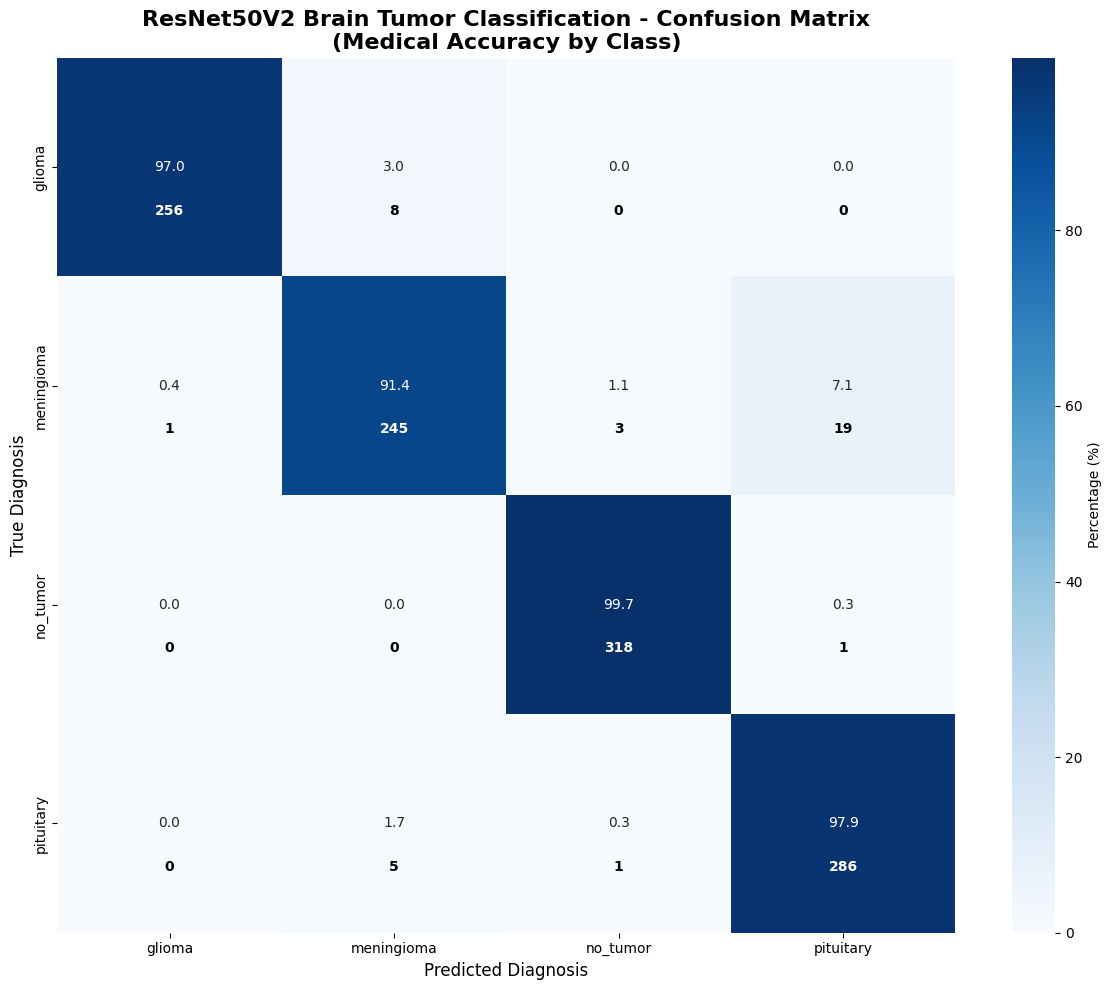

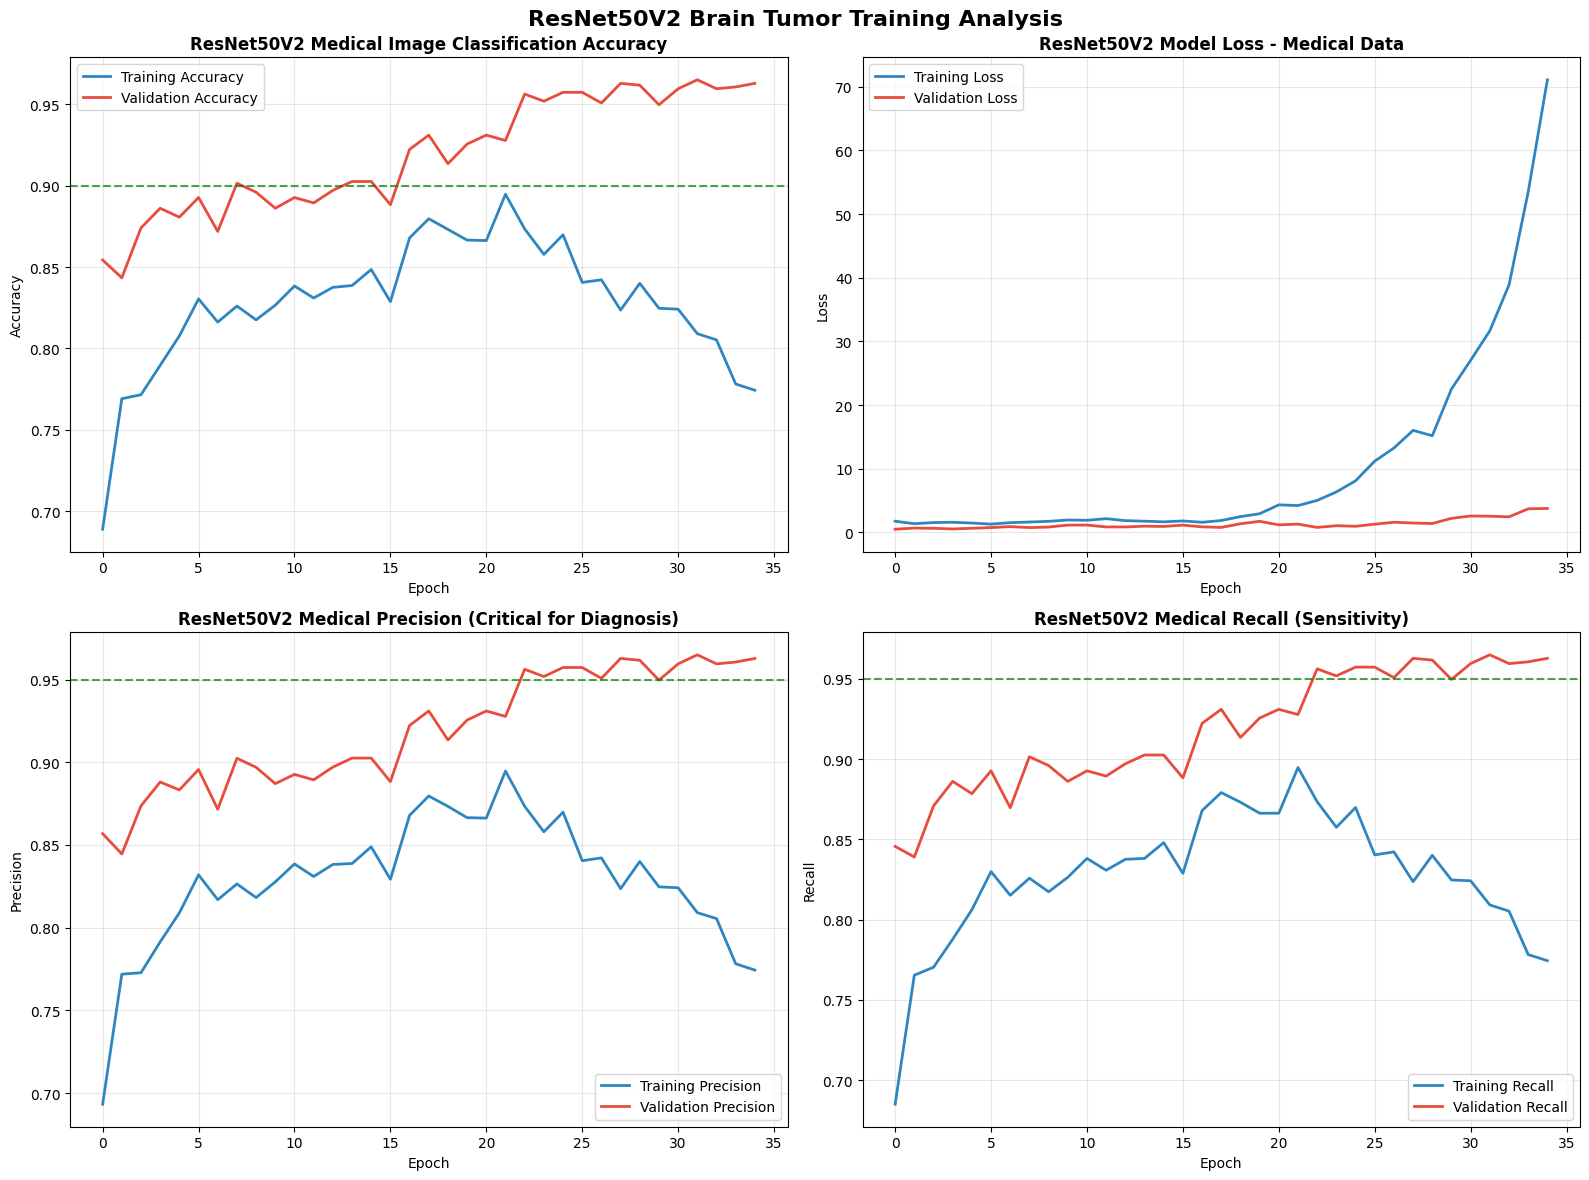

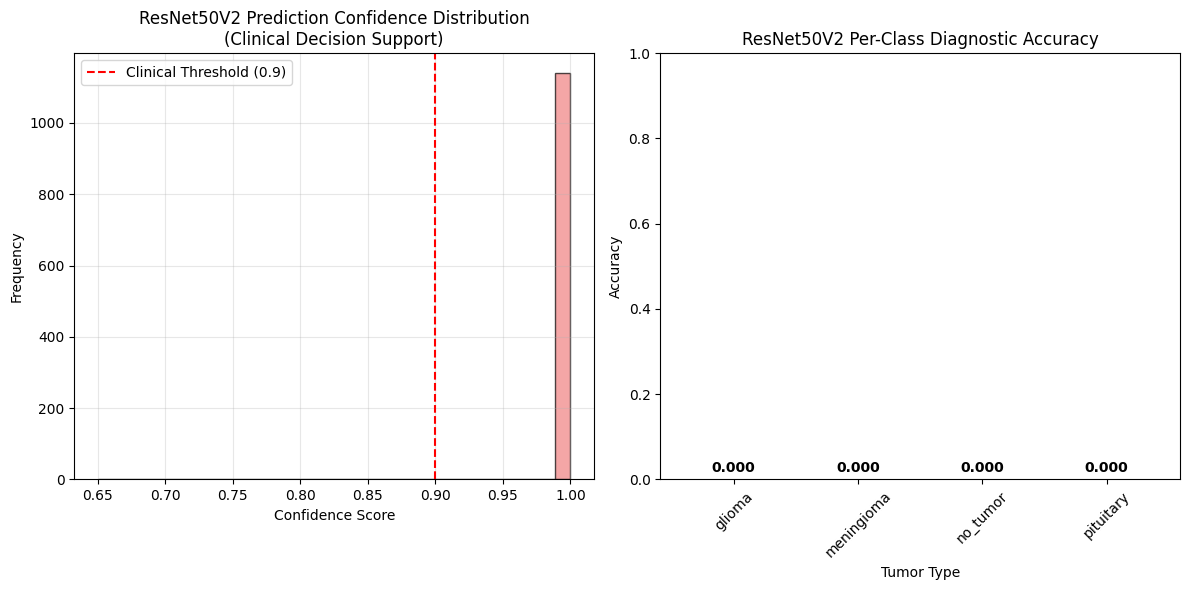


🏥 ResNet50V2 Clinical Confidence Analysis:
  - Mean prediction confidence: 0.9995
  - Std prediction confidence: 0.0112
  - Min confidence: 0.6501
  - Max confidence: 1.0000

🎯 ResNet50V2 High Confidence Analysis (≥0.9):
  - High confidence predictions: 1141/1143 (99.8%)
  - Accuracy of high confidence predictions: 0.9684 (96.84%)

📊 ResNet50V2 Per-Class Confidence Analysis:
  - glioma: 0.9999 average confidence
  - meningioma: 1.0000 average confidence
  - no_tumor: 0.9985 average confidence
  - pituitary: 0.9999 average confidence

🏥 ResNet50V2 Clinical Model Summary:
🧠 ResNet50V2 Brain Tumor Classification System
📊 Overall Test Accuracy: 0.9668 (96.68%)
🎯 High Confidence Predictions: 1141/1143 (99.8%)
💾 Best Model Saved: best_brain_tumor_resnet_model.h5
📈 Total Training Epochs: 35

🏥 Clinical Recommendations:
✅ ResNet50V2 shows excellent performance for clinical support

⚠️ IMPORTANT: This model is for research purposes only.
   Clinical decisions should always involve medical prof

In [20]:
# =============================================================================
# Comprehensive Evaluation and Visualization for ResNet50V2
# =============================================================================

print("\n📈 Creating comprehensive visualization and analysis for ResNet50V2...")

# Get predictions from ResNet model
test_generator.reset()
predictions_resnet = model_resnet.predict(test_generator, verbose=1)
predicted_classes_resnet = np.argmax(predictions_resnet, axis=1)
prediction_probabilities_resnet = np.max(predictions_resnet, axis=1)

true_classes_resnet = test_generator.classes
class_labels_resnet = list(test_generator.class_indices.keys())

# Enhanced Confusion Matrix for ResNet50V2
cm_resnet = confusion_matrix(true_classes_resnet, predicted_classes_resnet)
plt.figure(figsize=(12, 10))

# Calculate percentages for medical interpretation
cm_percent_resnet = cm_resnet.astype('float') / cm_resnet.sum(axis=1)[:, np.newaxis] * 100

# Create heatmap with both counts and percentages
sns.heatmap(cm_percent_resnet, annot=True, fmt='.1f', cmap='Blues', 
            xticklabels=class_labels_resnet, yticklabels=class_labels_resnet,
            cbar_kws={'label': 'Percentage (%)'})

plt.title('ResNet50V2 Brain Tumor Classification - Confusion Matrix\n(Medical Accuracy by Class)', 
          fontsize=16, fontweight='bold')
plt.ylabel('True Diagnosis', fontsize=12)
plt.xlabel('Predicted Diagnosis', fontsize=12)

# Add text annotations for clinical interpretation
for i in range(len(class_labels_resnet)):
    for j in range(len(class_labels_resnet)):
        if i == j:
            color = 'white' if cm_percent_resnet[i, j] > 50 else 'black'
        else:
            color = 'red' if cm_percent_resnet[i, j] > 10 else 'black'
        plt.text(j + 0.5, i + 0.7, f'{cm_resnet[i, j]}', 
                ha='center', va='center', color=color, fontweight='bold')

plt.tight_layout()
plt.show()

# Training History for ResNet50V2
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('ResNet50V2 Brain Tumor Training Analysis', fontsize=16, fontweight='bold')

# Accuracy Plot
axes[0, 0].plot(history_resnet_combined['accuracy'], label='Training Accuracy', linewidth=2, color='#2E86C1')
axes[0, 0].plot(history_resnet_combined['val_accuracy'], label='Validation Accuracy', linewidth=2, color='#E74C3C')
axes[0, 0].set_title('ResNet50V2 Medical Image Classification Accuracy', fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axhline(y=0.9, color='green', linestyle='--', alpha=0.7, label='Clinical Target (90%)')

# Loss Plot
axes[0, 1].plot(history_resnet_combined['loss'], label='Training Loss', linewidth=2, color='#2E86C1')
axes[0, 1].plot(history_resnet_combined['val_loss'], label='Validation Loss', linewidth=2, color='#E74C3C')
axes[0, 1].set_title('ResNet50V2 Model Loss - Medical Data', fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Precision Plot
if 'precision' in history_resnet_combined:
    axes[1, 0].plot(history_resnet_combined['precision'], label='Training Precision', linewidth=2, color='#2E86C1')
    axes[1, 0].plot(history_resnet_combined['val_precision'], label='Validation Precision', linewidth=2, color='#E74C3C')
    axes[1, 0].set_title('ResNet50V2 Medical Precision (Critical for Diagnosis)', fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].axhline(y=0.95, color='green', linestyle='--', alpha=0.7, label='Medical Target (95%)')

# Recall Plot
if 'recall' in history_resnet_combined:
    axes[1, 1].plot(history_resnet_combined['recall'], label='Training Recall', linewidth=2, color='#2E86C1')
    axes[1, 1].plot(history_resnet_combined['val_recall'], label='Validation Recall', linewidth=2, color='#E74C3C')
    axes[1, 1].set_title('ResNet50V2 Medical Recall (Sensitivity)', fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].axhline(y=0.95, color='green', linestyle='--', alpha=0.7, label='Medical Target (95%)')

plt.tight_layout()
plt.show()

# Clinical Confidence Distribution for ResNet50V2
plt.figure(figsize=(12, 6))

high_confidence_threshold_resnet = 0.9
high_confidence_predictions_resnet = prediction_probabilities_resnet >= high_confidence_threshold_resnet

# Overall confidence distribution
plt.subplot(1, 2, 1)
plt.hist(prediction_probabilities_resnet, bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
plt.axvline(high_confidence_threshold_resnet, color='red', linestyle='--', 
           label=f'Clinical Threshold ({high_confidence_threshold_resnet:.1f})')
plt.title('ResNet50V2 Prediction Confidence Distribution\n(Clinical Decision Support)')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

# Per-class accuracy for ResNet50V2
plt.subplot(1, 2, 2)
class_accuracies_resnet = []
for i, class_name in enumerate(class_labels_resnet):
    class_mask = true_classes_resnet == i
    if np.any(class_mask):
        accuracy = np.mean(predicted_classes_resnet[class_mask] == true_classes_resnet[class_mask])
        class_accuracies_resnet.append(accuracy)
    else:
        class_accuracies_resnet.append(0)

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
bars = plt.bar(class_labels_resnet, class_accuracies_resnet, color=colors[:len(class_labels_resnet)])
plt.title('ResNet50V2 Per-Class Diagnostic Accuracy')
plt.xlabel('Tumor Type')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.ylim(0, 1)

# Add value labels on bars
for bar, acc in zip(bars, class_accuracies_resnet):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Clinical confidence analysis for ResNet50V2
print(f"\n🏥 ResNet50V2 Clinical Confidence Analysis:")
print(f"  - Mean prediction confidence: {np.mean(prediction_probabilities_resnet):.4f}")
print(f"  - Std prediction confidence: {np.std(prediction_probabilities_resnet):.4f}")
print(f"  - Min confidence: {np.min(prediction_probabilities_resnet):.4f}")
print(f"  - Max confidence: {np.max(prediction_probabilities_resnet):.4f}")

# Calculate high confidence accuracy for ResNet50V2
predicted_classes_resnet = np.array(predicted_classes_resnet)
true_classes_resnet = np.array(true_classes_resnet)

if np.any(high_confidence_predictions_resnet):
    high_conf_correct_resnet = predicted_classes_resnet[high_confidence_predictions_resnet] == true_classes_resnet[high_confidence_predictions_resnet]
    high_conf_accuracy_resnet = np.mean(high_conf_correct_resnet)
else:
    high_conf_accuracy_resnet = 0

print(f"\n🎯 ResNet50V2 High Confidence Analysis (≥{high_confidence_threshold_resnet:.1f}):")
print(f"  - High confidence predictions: {np.sum(high_confidence_predictions_resnet)}/{len(predictions_resnet)} ({np.mean(high_confidence_predictions_resnet)*100:.1f}%)")
if np.any(high_confidence_predictions_resnet):
    print(f"  - Accuracy of high confidence predictions: {high_conf_accuracy_resnet:.4f} ({high_conf_accuracy_resnet*100:.2f}%)")

# Per-class confidence analysis for ResNet50V2
print(f"\n📊 ResNet50V2 Per-Class Confidence Analysis:")
for i, class_name in enumerate(class_labels_resnet):
    class_mask = predicted_classes_resnet == i
    if np.any(class_mask):
        class_confidence = np.mean(prediction_probabilities_resnet[class_mask])
        print(f"  - {class_name}: {class_confidence:.4f} average confidence")

# Final Clinical Summary for ResNet50V2
print("\n🏥 ResNet50V2 Clinical Model Summary:")
print("="*50)
print(f"🧠 ResNet50V2 Brain Tumor Classification System")
print(f"📊 Overall Test Accuracy: {test_results_resnet[1]:.4f} ({test_results_resnet[1]*100:.2f}%)")
print(f"🎯 High Confidence Predictions: {np.sum(high_confidence_predictions_resnet)}/{len(predictions_resnet)} ({np.mean(high_confidence_predictions_resnet)*100:.1f}%)")
print(f"💾 Best Model Saved: best_brain_tumor_resnet_model.h5")
print(f"📈 Total Training Epochs: {len(history_resnet_combined['accuracy'])}")
print("\n🏥 Clinical Recommendations:")
if test_results_resnet[1] >= 0.9:
    print("✅ ResNet50V2 shows excellent performance for clinical support")
elif test_results_resnet[1] >= 0.8:
    print("⚠️ ResNet50V2 shows good performance but needs additional validation")
else:
    print("❌ ResNet50V2 needs improvement before clinical deployment")
print("\n⚠️ IMPORTANT: This model is for research purposes only.")
print("   Clinical decisions should always involve medical professionals.")

# Detailed Classification Report for ResNet50V2
print("\n📋 ResNet50V2 Detailed Classification Report:")
print(classification_report(true_classes_resnet, predicted_classes_resnet, target_names=class_labels_resnet, digits=4))

In [21]:
print("big success")

big success
